# Proyecto Final Taller de Comunicaciones

## Librerías 

In [1]:
# Se cargan las bibliotecas de pandas , numpy y scipy
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
import numpy as np
import matplotlib. pyplot as plt
import scipy
from scipy import stats
from scipy.stats import norm
import seaborn as sns
import numpy as np
#from outliers import smirnov_grubbs as grubbs
import matplotlib.pyplot as plt
import math
import scipy.signal as signal
from matplotlib import rcParams
from scipy.signal import cont2discrete, lti, dlti, dstep
from numpy import sum,isrealobj,sqrt
from numpy.random import standard_normal
import numpy as np
import matplotlib.pyplot as plt


## Análisis de los Datos 

Se importan los datos del Dataset

In [2]:
datos = pd.read_excel (r'C:\TEC\Semestre 9\Taller De Comunicaciones Electricas\Proyecto final\Dataset.xlsx', sheet_name= 'Hoja1', header = 0)

In [3]:
BPM_DF = pd.DataFrame(datos)

### Análisis Cuantitativo

Vamos a realizar un análisis de los datos, se calcula el pvalue, desviación estándar y el promedio por medio de la función Anderson para probar la normalidad de los datos

In [4]:
# normality test
result = scipy.stats.anderson(BPM_DF['BPM'], dist='norm')
print('Statistic: %.3f' % result.statistic)
p = 0
for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < result.critical_values[i]:
        print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
    else:
        print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

Statistic: 0.577
15.000: 0.559, data does not look normal (reject H0)
10.000: 0.637, data looks normal (fail to reject H0)
5.000: 0.764, data looks normal (fail to reject H0)
2.500: 0.891, data looks normal (fail to reject H0)
1.000: 1.060, data looks normal (fail to reject H0)


In [5]:
result

AndersonResult(statistic=0.5773116880453841, critical_values=array([0.559, 0.637, 0.764, 0.891, 1.06 ]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

In [6]:
#grubbs.max_test_outliers(BPM_DF['BPM'], alpha=0.5)

### Análisis Gráfico

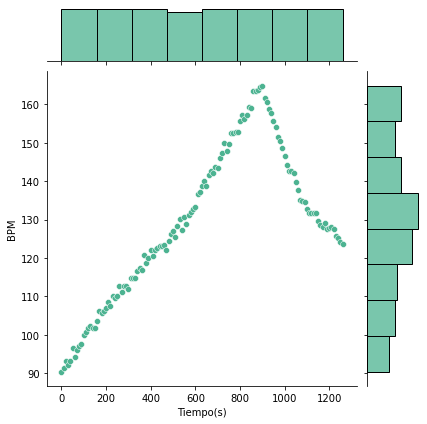

In [7]:
sns.jointplot(x=BPM_DF['Tiempo(s)'], y=BPM_DF['BPM'], color="#4CB391")

<AxesSubplot:xlabel='BPM', ylabel='Count'>

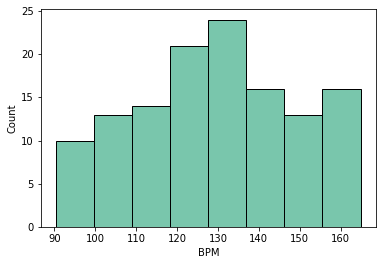

In [8]:
sns.histplot(data = BPM_DF, x = BPM_DF['BPM'], color="#4CB391")

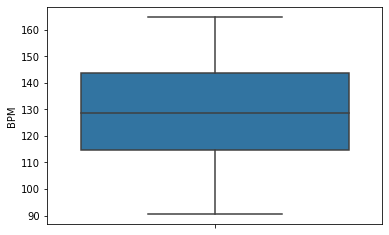

In [9]:
ax = sns.boxplot(y="BPM", data=BPM_DF)

----------------------------------

## Implementación del Filtro

### Para el Filtro de Topología Simple Model Average (SMA)

In [10]:
BPM_DF['SMA_5'] = BPM_DF['BPM'].rolling(5, min_periods=1).mean()

In [11]:
#BPM_DF['SMA_10'] = BPM_DF['BPM'].rolling(10, min_periods=1).mean()

In [12]:
BPM_DF['SMA_20'] = BPM_DF['BPM'].rolling(20, min_periods=1).mean()

In [13]:
BPM_Filter_SMA = BPM_DF.drop(columns=['Tiempo(s)'])

In [14]:
BPM_Filter_SMA = BPM_Filter_SMA.rename(columns={"BPM": "Original"})

Text(0, 0.5, 'BPM')

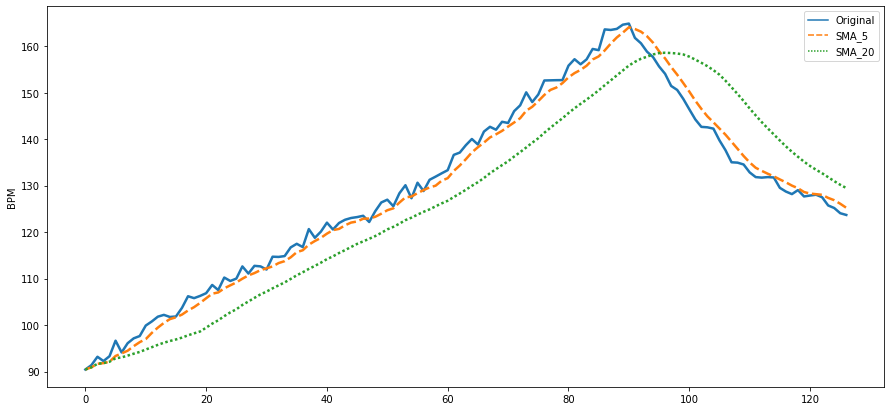

In [15]:
plt.figure(figsize=[15,7])
sns.lineplot(data = BPM_Filter_SMA, palette="tab10", linewidth=2.5)
plt.ylabel("BPM")

### Para el Filtro de Topología (CMA) Y (EMA)

In [16]:
BPM_DF['CMA'] = BPM_DF['BPM'].expanding().mean()

In [17]:
BPM_DF['EMA_0.2'] = BPM_DF['BPM'].ewm(alpha=0.2, adjust=False).mean()

In [18]:
BPM_Filter_CMA = BPM_DF.drop(columns=['Tiempo(s)'])

In [19]:
BPM_Filter_CMA = BPM_Filter_CMA.rename(columns={"BPM": "Original"})

Text(0, 0.5, 'BPM')

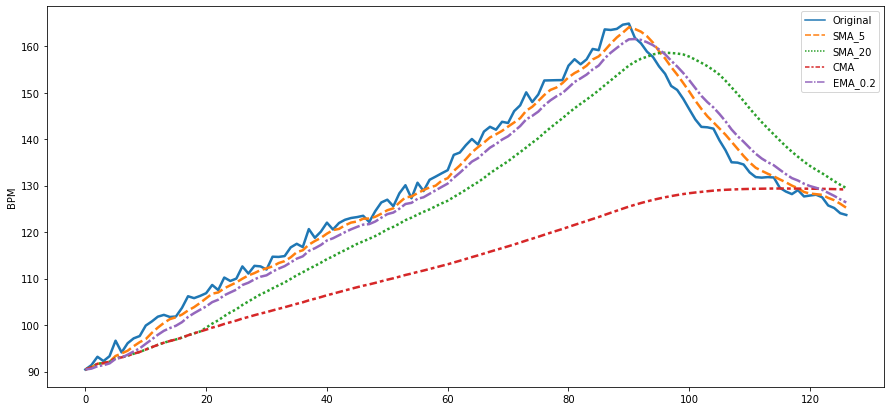

In [20]:
plt.figure(figsize=[15,7])
sns.lineplot(data = BPM_Filter_CMA, palette="tab10", linewidth=2.5)
plt.ylabel("BPM")

## Discretizacion de la señal suavizada

In [21]:
#Se crea una función para poder cuantizar la señal

def cuantizador(x, cuant_mínimo=-1.0, cuant_maximo=1.0, nivel=5):

    x_normalizado = (x-cuant_mínimo) * (nivel-1) / (cuant_maximo-cuant_mínimo) #Se toma el dato normalizado
    x_normalizado[x_normalizado > nivel - 1] = nivel - 1
    x_normalizado[x_normalizado < 0] = 0
    x_cuant_norm = np.around(x_normalizado)
    x_cuant = round((x_cuant_norm) * (cuant_maximo-cuant_mínimo) / (nivel-1) + cuant_mínimo).astype('int')
    return x_cuant

In [22]:
x=BPM_Filter_SMA['SMA_5']
x

0       90.435881
1       90.905720
2       91.662862
3       91.810414
4       92.107765
          ...    
122    128.012833
123    127.351940
124    126.855292
125    126.094034
126    125.224547
Name: SMA_5, Length: 127, dtype: float64

### Grafica de la señal discretizada 

In [23]:
#Se crea una función  para poder observar la señal discretizada 

def grafica_discreta(x, t, x_cuant, xlim=None, ylim=None, title=''):
    
    plt.figure(figsize=[15,7]) #Se dimensiona el gráfico
    
    #Se colocan ciertos parámetros para el gráfico
    plt.plot(t, x, color='maroon', linewidth=5.0, linestyle='-', label='Señal original filtrada (SMA_5)')
    plt.plot(t, x_cuant, color='yellow', linewidth=2.0, linestyle='-', label='Señal Cuantificada')
    
    #Se definen limites del gráfico
    if xlim is None:
        plt.xlim([0, t[-1]])
    else:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)
    
    #Se colocan ciertos parámetros de leyendas y nombres a ejes
    plt.xlabel('Tiempo (s)')
    plt.ylabel('BPM')
    plt.title(title)
    plt.legend(loc='upper right', framealpha=1)
    plt.tight_layout()
    
    #Se muestra el gráfico
    plt.show()

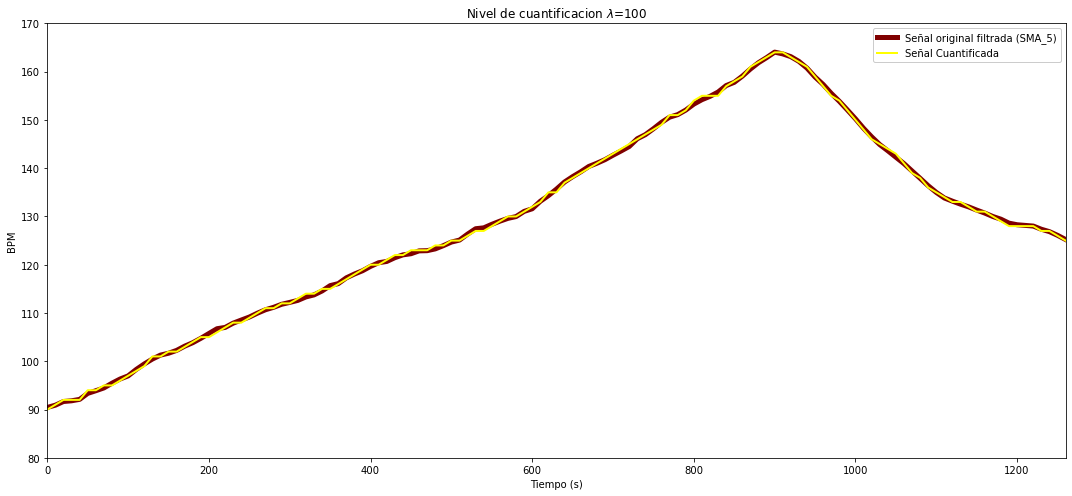

In [24]:
t=[]

#Se Definen ciertos parámetros
for i in range(0, 1270, 10):
    t.append(i)
    
nivel = 100

#Se grafica la señal cuantificada
x_cuant = cuantizador(x, cuant_mínimo=80, cuant_maximo=170, nivel=nivel)
grafica_discreta(x, t, x_cuant, xlim=[0, 1260], ylim=[80,170], 
title=r'Nivel de cuantificacion $\lambda$=$%d$'%(nivel));


## Convertir las muestras discretas y convertirlas a binario

En esta sección se estará creando una función para convertir número de decimal a binario

In [25]:
max(x_cuant)

164

In [26]:
#Se crea una función para convertir números de decimal a binario

def dec_to_bin(x):
    return int(bin(x)[2:])

In [27]:

BPM_Discreta=[] # Se crea una lista vacía

# Se añaden los valores cuantizados a la lista anterior
for i in x_cuant:
    BPM_Discreta.append(i-90)

In [28]:

BPM_BIN=[] #Se crea una lista vacía

# Se añaden los valores cuantizados a la lista anterior
for i in BPM_Discreta:
    BPM_BIN.append(dec_to_bin(i))

In [29]:

BPM_BIN_7bits=[] #Se crea una lista vacía

# Se añaden los valores cuantizados a la lista anterior
for i in BPM_BIN:
     BPM_BIN_7bits.append(str(i).rjust(11, '0'))

## Codificacion Hamming

En esta sección se estará realizando una codificación de hamming con el objetivo de poder detectar y corregir errores, mediante una revision en los datos recibidos.

In [30]:
#Se implementa un código en donde se aplica la codificacion hamming

def calcRedundantBits(m):
 
    # Se utiliza la fórmula 2 ^ r >= m + r + 1, para poder observar la redundancia de los datos
 
    for i in range(m):
        if(2**i >= m + i + 1):
            return i
 
#Se crea una función para poder obtener las posiciones de los bits de redundancia 

def posRedundantBits(data, r): 
 
    # Los bits de redundancia se colocan en la posicion que les corresoponde a la potencia de 2
    
    j = 0
    k = 1
    m = len(data)
    res = ''
 
    for i in range(1, m + r+1): #Si la posicion es potencia de 2, se inserta un 0, sino se añade el dato
        if(i == 2**j):
            res = res + '0'
            j += 1
        else:
            res = res + data[-1 * k]
            k += 1
            
    return res[::-1]
 
    
#Se crea una función para los bits de paridad 

def calcParidadtyBits(arreglo, r):
    
    n = len(arreglo)

    for i in range(r):
        val = 0
        for j in range(1, n + 1):
 
            if(j & (2**i) == (2**i)):
                val = val ^ int(arreglo[-1 * j])
            
        arreglo = arreglo[:n-(2**i)] + str(val) + arreglo[n-(2**i)+1:] # Concatenación : (0 to n - 2^r) + bit de baridad + (n - 2^r + 1 to n)
    
    return arreglo #Se devuelve el arreglo
 
#Se crea una función para la sección de la detección de errores

def detectError(arreglo, nr):
    n = len(arreglo)
    res = 0
 
    # Se calcula los bits de paridad 
    
    for i in range(nr):
        val = 0
        for j in range(1, n + 1):
            if(j & (2**i) == (2**i)):
                val = val ^ int(arreglo[-1 * j])
 
        res = res + val*(10**i)
 
    # Se hace la conversion de binario a decimal
    
    return int(str(res), 2)

In [31]:

BPM_hamming=[] #Se crea una lista vacía para los valores de hamming

for data  in BPM_BIN_7bits:  # Para añadir los bits transmitidos

# Se calcula los requerimientos de los bits de redundancia
    m = len(data)
    r = calcRedundantBits(m)

# Se determina la posicion de los bits de redundancia
    arreglo = posRedundantBits(data, r)

# Se determinan los bits de paridad
    arreglo = calcParidadtyBits(arreglo, r)
        
    BPM_hamming.append(arreglo)

#Se muestra al usuario los datos transferidos, así como el error de datos y la pos del error

    print("El dato transferido es:" + arreglo) 
        # si se modifica el arreglo qeu contiene el mensaje para insertarle un error
        # el algoritmo detectaria en cual posicion esta el error
        # 000000000000000 -> 000000000000010

    Vector_error = '000000000000000'
    print("El vector de error es: " + Vector_error)
    correction = detectError(Vector_error, r)
    print("La posisición del error es: " + str(correction))
    print ('-------------------------------------')
    

El dato transferido es:000000000000000
El vector de error es: 000000000000000
La posisición del error es: 0
-------------------------------------
El dato transferido es:000000000000111
El vector de error es: 000000000000000
La posisición del error es: 0
-------------------------------------
El dato transferido es:000000000011001
El vector de error es: 000000000000000
La posisición del error es: 0
-------------------------------------
El dato transferido es:000000000011001
El vector de error es: 000000000000000
La posisición del error es: 0
-------------------------------------
El dato transferido es:000000000011001
El vector de error es: 000000000000000
La posisición del error es: 0
-------------------------------------
El dato transferido es:000000000101010
El vector de error es: 000000000000000
La posisición del error es: 0
-------------------------------------
El dato transferido es:000000000101010
El vector de error es: 000000000000000
La posisición del error es: 0
----------------

## Tabla Resumen

En esta sección se crea una matriz resumen, para poder observar las modificaciones realizadas a los datos a través del tiempo

In [32]:
Comparacion_df = pd.DataFrame()
Comparacion_df['Tiempo(s)']=t
Comparacion_df['Señal Original']=BPM_DF['BPM']
Comparacion_df['Datos filtrados (SMA_5)']=x
Comparacion_df['Datos cuantificados']=x_cuant
Comparacion_df['Datos codificados']=BPM_BIN_7bits
Comparacion_df['Datos codificados por Hamming'] = BPM_hamming


In [33]:
Comparacion_df

Tiempo(s)  Señal Original  Datos filtrados (SMA_5)  Datos cuantificados  \
0            0       90.435881                90.435881                   90   
1           10       91.375558                90.905720                   91   
2           20       93.177147                91.662862                   92   
3           30       92.253070                91.810414                   92   
4           40       93.297168                92.107765                   92   
..         ...             ...                      ...                  ...   
122       1220      127.489200               128.012833                  128   
123       1230      125.722564               127.351940                  127   
124       1240      125.176371               126.855292                  127   
125       1250      124.053356               126.094034                  126   
126       1260      123.681245               125.224547                  125   

    Datos codificados Datos codificados por Hamming  
0         00000000000               000000000000000  
1         00000000001               000000000000111  
2         00000000010               000000000011001  
3         00000000010               000000000011001  
4         00000000010               000000000011001  
..                ...                           ...  
122       00000100110               000001010110001  
123       00000100101               000001010101111  
124       00000100101               000001010101111  
125       00000100100               000001010101000  
126       00000100011               000001010011100  

[127 rows x 6 columns]

## Agregamos Ruido Blanco Gaussiano

In [34]:
# Se procede a realizar una función para poder agregar ruido Gaussiano a la señal a enviar, en este módulo se procede a agregar una funcion 
#en donde se crea una función de ruido AWGN a una señal de entrada, para generar un vector de la señal resultante de la SNR especificada en dB.
# Tambien en este módulo se devuelve un vector de ruido que se suma a la señal de entrada y la densidad espectral de potencia N0 del ruido.
# En donde L es un vector de sobremuestreo (Se aplica una simulación de forma de onda ) en este caso se toma el valor de L = 1

### Para la señal a enviar

In [35]:
#Se crea un for para poder darle un formato de arreglo a los bits de entrada para que los pueda recibir el módulo del ruido gaussiano

#Se crea una lista
Señal = []

#Se recorren los datos codificados por hamming y se van agregando a una lista
for x in BPM_hamming:
    aux = [int(a) for a in str(x)]
    Señal.append(aux)
    
#Se convierte la lista en un arreglo de Numpy para su posterior tratamiento
señal_enviada = np.array(Señal)


### Ruido del Canal 

In [36]:
#Relación señal ruido del canal en dB
SNRdB = 19.6864

# Se procede a realizar una función para poder agregar ruido Gaussiano a la señal a enviar, en este módulo se procede a agregar una funcion en donde se crea una función de ruido AWGN a una señal de entrada, para generar un vector de la señal resultante de la SNR especificada en dB.
# Tambien en este módulo se devuelve un vector de ruido que se suma a la señal de entrada y la densidad espectral de potencia N0 del ruido.
# En donde L es un vector de sobremuestreo (Se aplica una simulación de forma de onda ) en este caso se toma el valor de L = 1
# señal_enviada = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1 ])

#Se calcula el SNR en lineales
SNR_lineal = 10**(SNRdB/10)

#Se comprueba si es un vector bidimensional
if señal_enviada.ndim==2:
    P=1*sum(abs(señal_enviada)**2)/len(señal_enviada)
    
#Para el caso de que sea multidimencional MFSK    
else:
    P=1*sum(sum(abs(señal_enviada)**2))/len(señal_enviada) 
    
#Encontramos la densidad espectral de potencia del ruido (N0)    
N0=P/SNR_lineal

#Se verifica si la entrada es real o compleja
if isrealobj(señal_enviada):
    
    #Se encuentra el vector de ruido que se le va a agregar a la señal recibida
    Ruido = sqrt(N0/2)*standard_normal(señal_enviada.shape)
else:
    Ruido = sqrt(N0/2)*(standard_normal(señal_enviada.shape)+1j*standard_normal(señal_enviada.shape))


In [59]:
SNR_lineal

93.03363714326235

In [37]:
#Se muestra la Señal enviada desde el codificador Hamming
señal_enviada

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0]])

In [38]:
#Se muestra el vector de ruido que se le va a agregar a la señal enviada 
Ruido

array([[-0.42314222, -0.2767415 , -0.14527535, ...,  0.04411339,
        -0.16999674,  0.50108588],
       [ 0.06979034, -0.15711934, -0.06538418, ..., -0.14136087,
         0.07249733, -0.12918224],
       [ 0.04668277, -0.00487708,  0.0629393 , ..., -0.01546092,
         0.05306089,  0.07908804],
       ...,
       [-0.03553024,  0.47192029,  0.10007285, ..., -0.11346748,
        -0.16396583,  0.00067836],
       [-0.02883999, -0.28166557,  0.03355231, ...,  0.04428526,
        -0.09808288, -0.01642671],
       [-0.31109024,  0.22869723,  0.04435626, ...,  0.00947355,
         0.2592514 ,  0.21190202]])

In [39]:
#Se comprueba la extencion de la señal enviada 
len(señal_enviada)

127

La senal enviada es: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

El ruido anadido a la senal es: [-0.42314222 -0.2767415  -0.14527535  0.02760538  0.25417136 -0.19319891
  0.05596488  0.26895773 -0.22525225  0.04563938 -0.21876827 -0.01205059
  0.04411339 -0.16999674  0.50108588]

La senal resultante con el ruido es: [-0.42314222 -0.2767415  -0.14527535  0.02760538  0.25417136 -0.19319891
  0.05596488  0.26895773 -0.22525225  0.04563938 -0.21876827 -0.01205059
  0.04411339 -0.16999674  0.50108588]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



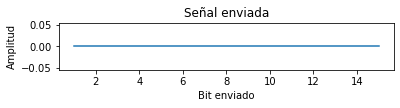

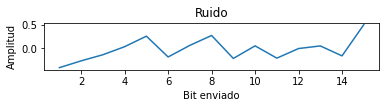

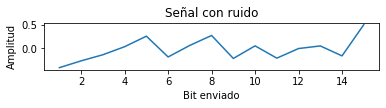

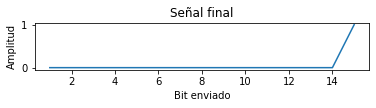

La senal enviada es: [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]

El ruido anadido a la senal es: [ 0.06979034 -0.15711934 -0.06538418 -0.04551626 -0.386049    0.09296691
  0.01103217  0.21251898  0.02302361 -0.02168135 -0.04873432 -0.10003303
 -0.14136087  0.07249733 -0.12918224]

La senal resultante con el ruido es: [ 0.06979034 -0.15711934 -0.06538418 -0.04551626 -0.386049    0.09296691
  0.01103217  0.21251898  0.02302361 -0.02168135 -0.04873432 -0.10003303
  0.55863913  0.77249733  0.57081776]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



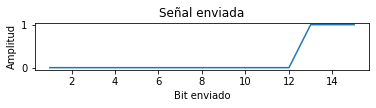

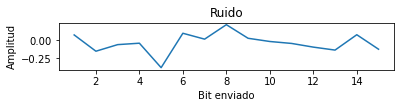

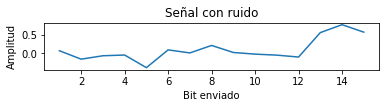

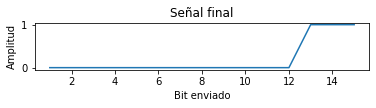

La senal enviada es: [0 0 0 0 0 0 0 0 0 0 1 1 0 0 1]

El ruido anadido a la senal es: [ 0.04668277 -0.00487708  0.0629393   0.14440695  0.24391801  0.26539511
 -0.01871428  0.02113924  0.15477938  0.00158352  0.04243716 -0.14457365
 -0.01546092  0.05306089  0.07908804]

La senal resultante con el ruido es: [ 0.04668277 -0.00487708  0.0629393   0.14440695  0.24391801  0.26539511
 -0.01871428  0.02113924  0.15477938  0.00158352  0.74243716  0.55542635
 -0.01546092  0.05306089  0.77908804]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



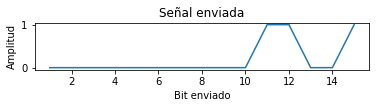

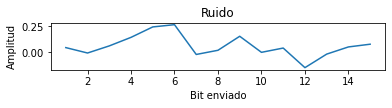

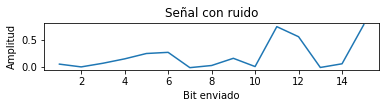

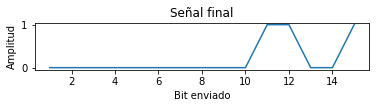

La senal enviada es: [0 0 0 0 0 0 0 0 0 0 1 1 0 0 1]

El ruido anadido a la senal es: [ 0.14237687 -0.238913   -0.13131151 -0.01457205  0.48599052  0.0957811
 -0.12988018  0.19630382 -0.09113542 -0.13669317 -0.20133838  0.08780149
  0.0467287  -0.27931735  0.1131756 ]

La senal resultante con el ruido es: [ 0.14237687 -0.238913   -0.13131151 -0.01457205  0.48599052  0.0957811
 -0.12988018  0.19630382 -0.09113542 -0.13669317  0.49866162  0.78780149
  0.0467287  -0.27931735  0.8131756 ]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



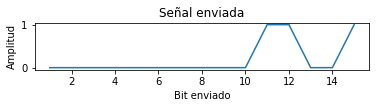

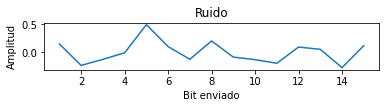

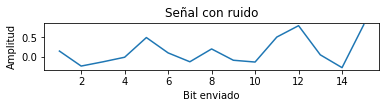

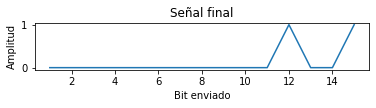

La senal enviada es: [0 0 0 0 0 0 0 0 0 0 1 1 0 0 1]

El ruido anadido a la senal es: [-0.11661588  0.1934712  -0.09061557  0.19530685 -0.06156075  0.252887
 -0.13279456 -0.12047494 -0.25191255 -0.06179874  0.26504285  0.39642361
  0.14974073 -0.13400138 -0.04239893]

La senal resultante con el ruido es: [-0.11661588  0.1934712  -0.09061557  0.19530685 -0.06156075  0.252887
 -0.13279456 -0.12047494 -0.25191255 -0.06179874  0.96504285  1.09642361
  0.14974073 -0.13400138  0.65760107]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



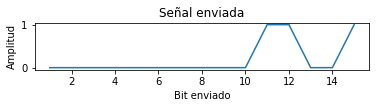

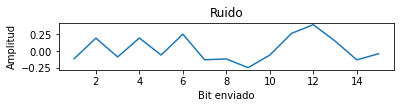

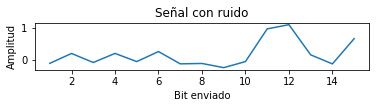

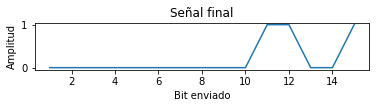

La senal enviada es: [0 0 0 0 0 0 0 0 0 1 0 1 0 1 0]

El ruido anadido a la senal es: [ 0.05526352  0.30162082  0.13988885  0.01381597  0.06201443  0.16270151
 -0.33169487  0.13638378  0.28768095 -0.13251969  0.12392956  0.37934271
  0.02450194 -0.21524901  0.04557749]

La senal resultante con el ruido es: [ 0.05526352  0.30162082  0.13988885  0.01381597  0.06201443  0.16270151
 -0.33169487  0.13638378  0.28768095  0.56748031  0.12392956  1.07934271
  0.02450194  0.48475099  0.04557749]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



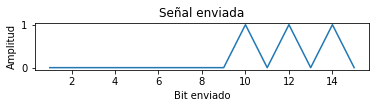

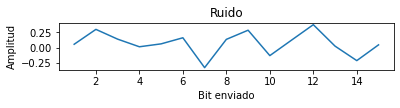

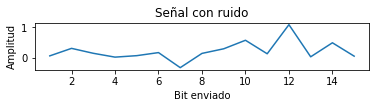

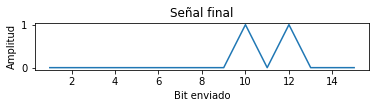

La senal enviada es: [0 0 0 0 0 0 0 0 0 1 0 1 0 1 0]

El ruido anadido a la senal es: [-0.13388363  0.16437516 -0.06266509  0.05944248 -0.12997836  0.09613928
 -0.17511203 -0.18606704  0.08973855 -0.3142861   0.4493002   0.07609217
  0.10929373 -0.30846364  0.0931303 ]

La senal resultante con el ruido es: [-0.13388363  0.16437516 -0.06266509  0.05944248 -0.12997836  0.09613928
 -0.17511203 -0.18606704  0.08973855  0.3857139   0.4493002   0.77609217
  0.10929373  0.39153636  0.0931303 ]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



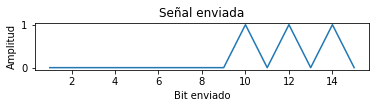

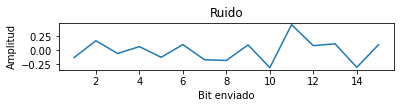

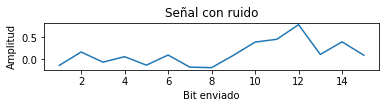

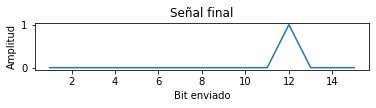

La senal enviada es: [0 0 0 0 0 0 0 0 0 1 0 1 1 0 1]

El ruido anadido a la senal es: [ 0.1708044  -0.00278344  0.12407273 -0.06234562  0.18254874 -0.15547833
  0.21644483  0.04495247 -0.14194039 -0.24121711  0.11762017 -0.18182622
  0.12254286  0.36951664  0.16210576]

La senal resultante con el ruido es: [ 0.1708044  -0.00278344  0.12407273 -0.06234562  0.18254874 -0.15547833
  0.21644483  0.04495247 -0.14194039  0.45878289  0.11762017  0.51817378
  0.82254286  0.36951664  0.86210576]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



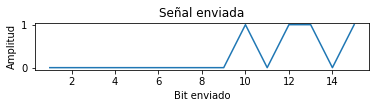

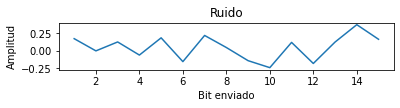

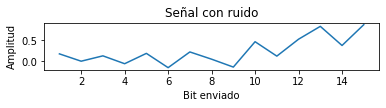

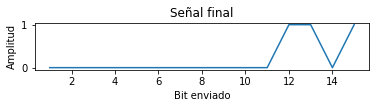

La senal enviada es: [0 0 0 0 0 0 0 0 0 1 0 1 1 0 1]

El ruido anadido a la senal es: [-0.22695541  0.20723065 -0.01007443 -0.00942762 -0.2914061   0.1402819
 -0.11059973 -0.00093524  0.028337    0.00823151 -0.11946705  0.07345152
 -0.22507671  0.07965021  0.11672817]

La senal resultante con el ruido es: [-0.22695541  0.20723065 -0.01007443 -0.00942762 -0.2914061   0.1402819
 -0.11059973 -0.00093524  0.028337    0.70823151 -0.11946705  0.77345152
  0.47492329  0.07965021  0.81672817]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



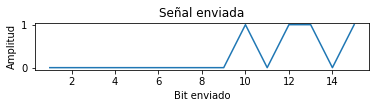

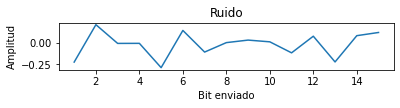

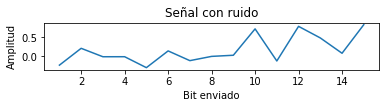

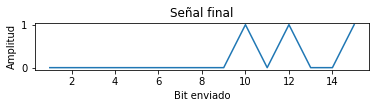

La senal enviada es: [0 0 0 0 0 0 0 0 0 1 1 0 0 1 1]

El ruido anadido a la senal es: [-0.31045746 -0.1811588   0.01673388  0.15490569 -0.16331698  0.0414781
 -0.08566343 -0.06871427 -0.01509982  0.13385849 -0.01716085  0.13729158
  0.11539762 -0.06904408  0.04700605]

La senal resultante con el ruido es: [-0.31045746 -0.1811588   0.01673388  0.15490569 -0.16331698  0.0414781
 -0.08566343 -0.06871427 -0.01509982  0.83385849  0.68283915  0.13729158
  0.11539762  0.63095592  0.74700605]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



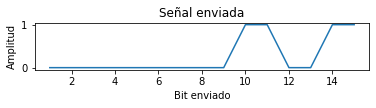

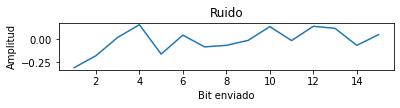

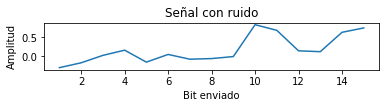

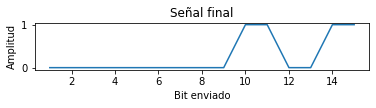

La senal enviada es: [0 0 0 0 0 0 0 0 0 1 1 0 1 0 0]

El ruido anadido a la senal es: [ 0.32445759  0.07358988 -0.10039933 -0.07574609  0.2557048   0.08445041
  0.11299302 -0.06013227  0.20242823 -0.26334143  0.40806061  0.06177693
  0.0757794   0.07189291 -0.21569291]

La senal resultante con el ruido es: [ 0.32445759  0.07358988 -0.10039933 -0.07574609  0.2557048   0.08445041
  0.11299302 -0.06013227  0.20242823  0.43665857  1.10806061  0.06177693
  0.7757794   0.07189291 -0.21569291]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



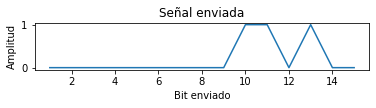

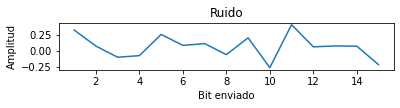

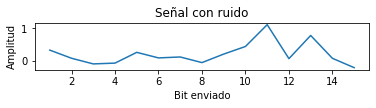

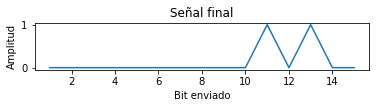

La senal enviada es: [0 0 0 0 0 0 0 0 1 0 0 1 0 1 1]

El ruido anadido a la senal es: [ 0.03116442  0.00137038 -0.09078773  0.19249078  0.14050191 -0.019436
 -0.0323364   0.17833797 -0.11918583  0.38175461  0.27592604  0.16350323
  0.17834842  0.10297537  0.19504861]

La senal resultante con el ruido es: [ 0.03116442  0.00137038 -0.09078773  0.19249078  0.14050191 -0.019436
 -0.0323364   0.17833797  0.58081417  0.38175461  0.27592604  0.86350323
  0.17834842  0.80297537  0.89504861]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



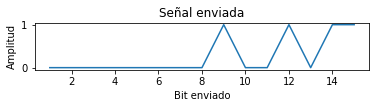

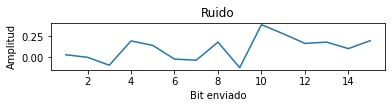

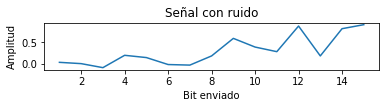

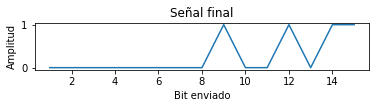

La senal enviada es: [0 0 0 0 0 0 0 0 1 0 0 1 1 0 0]

El ruido anadido a la senal es: [-0.08506915 -0.08062042  0.0507903  -0.18982433 -0.11119909  0.22454361
 -0.12673563  0.04517865 -0.25749398  0.19941173  0.04060464  0.19000788
 -0.0089031  -0.29253709 -0.20511258]

La senal resultante con el ruido es: [-0.08506915 -0.08062042  0.0507903  -0.18982433 -0.11119909  0.22454361
 -0.12673563  0.04517865  0.44250602  0.19941173  0.04060464  0.89000788
  0.6910969  -0.29253709 -0.20511258]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



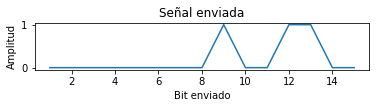

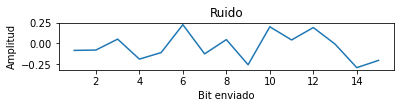

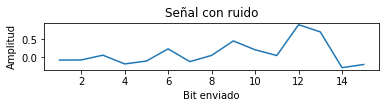

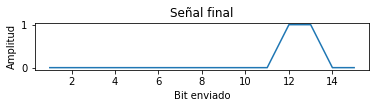

La senal enviada es: [0 0 0 0 0 0 0 0 1 0 1 0 1 0 1]

El ruido anadido a la senal es: [ 0.16962943 -0.38459656  0.2135439  -0.13960422 -0.02011439  0.08781605
  0.09497245 -0.15763883  0.02592493 -0.12888324  0.18502481 -0.2256902
  0.14356601 -0.1939082   0.09445414]

La senal resultante con el ruido es: [ 0.16962943 -0.38459656  0.2135439  -0.13960422 -0.02011439  0.08781605
  0.09497245 -0.15763883  0.72592493 -0.12888324  0.88502481 -0.2256902
  0.84356601 -0.1939082   0.79445414]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



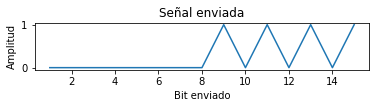

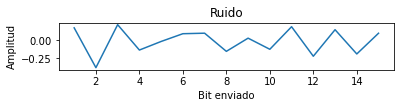

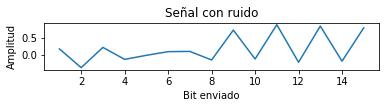

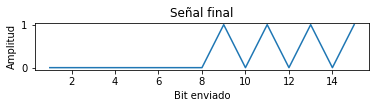

La senal enviada es: [0 0 0 0 0 0 0 0 1 0 1 0 1 0 1]

El ruido anadido a la senal es: [-0.01271034 -0.09432964 -0.12571792 -0.19771754  0.14180107  0.18499917
  0.09259711  0.16613632  0.04063482 -0.26797356 -0.11030974 -0.10978431
  0.26445756 -0.13441194 -0.11465065]

La senal resultante con el ruido es: [-0.01271034 -0.09432964 -0.12571792 -0.19771754  0.14180107  0.18499917
  0.09259711  0.16613632  0.74063482 -0.26797356  0.58969026 -0.10978431
  0.96445756 -0.13441194  0.58534935]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



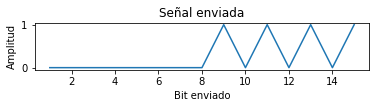

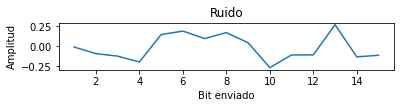

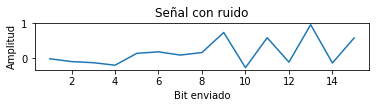

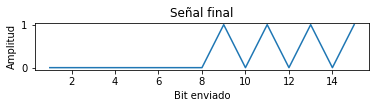

La senal enviada es: [0 0 0 0 0 0 0 0 1 1 0 0 0 0 1]

El ruido anadido a la senal es: [-0.21082046  0.03875142 -0.02561901 -0.03553304 -0.01280397 -0.1976737
  0.06127597 -0.05476226 -0.42206827  0.22761386  0.09824699  0.47742575
  0.01938864  0.11233713  0.23445886]

La senal resultante con el ruido es: [-0.21082046  0.03875142 -0.02561901 -0.03553304 -0.01280397 -0.1976737
  0.06127597 -0.05476226  0.27793173  0.92761386  0.09824699  0.47742575
  0.01938864  0.11233713  0.93445886]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



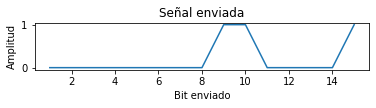

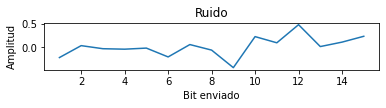

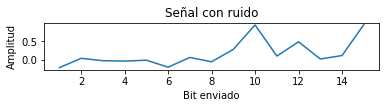

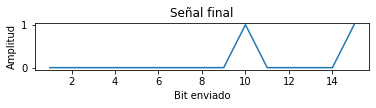

La senal enviada es: [0 0 0 0 0 0 0 0 1 1 0 0 0 0 1]

El ruido anadido a la senal es: [-0.2353348   0.02749784  0.05007139 -0.0903102  -0.07068943  0.04584017
  0.20606747  0.45067234 -0.19347767  0.01060766  0.00441648  0.04816542
 -0.06127213  0.31888927 -0.11512434]

La senal resultante con el ruido es: [-0.2353348   0.02749784  0.05007139 -0.0903102  -0.07068943  0.04584017
  0.20606747  0.45067234  0.50652233  0.71060766  0.00441648  0.04816542
 -0.06127213  0.31888927  0.58487566]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



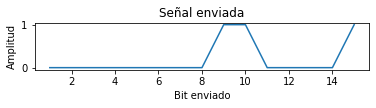

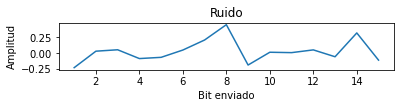

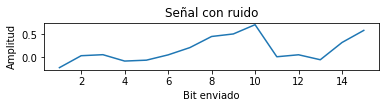

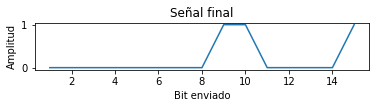

La senal enviada es: [0 0 0 0 0 0 0 0 1 1 0 0 1 1 0]

El ruido anadido a la senal es: [-0.2053092   0.04858636  0.14666505  0.01958577  0.23067045  0.0416293
  0.28960695  0.32288607  0.37506765  0.15475671 -0.05513534  0.06041887
  0.06293579  0.04839074  0.15601476]

La senal resultante con el ruido es: [-0.2053092   0.04858636  0.14666505  0.01958577  0.23067045  0.0416293
  0.28960695  0.32288607  1.07506765  0.85475671 -0.05513534  0.06041887
  0.76293579  0.74839074  0.15601476]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



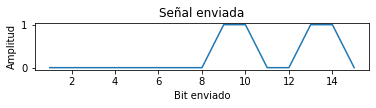

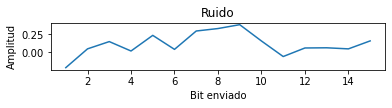

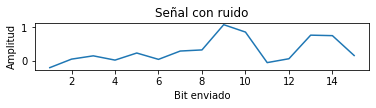

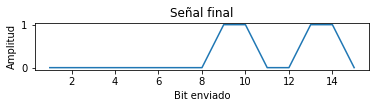

La senal enviada es: [0 0 0 0 0 0 0 0 1 1 1 1 0 0 0]

El ruido anadido a la senal es: [-0.23909987 -0.04456034  0.24915902  0.19608133  0.00772376  0.00468075
  0.14342721  0.08666064  0.01106779  0.2194232  -0.04505138 -0.26603473
 -0.05742811  0.2251635   0.29444461]

La senal resultante con el ruido es: [-0.23909987 -0.04456034  0.24915902  0.19608133  0.00772376  0.00468075
  0.14342721  0.08666064  0.71106779  0.9194232   0.65494862  0.43396527
 -0.05742811  0.2251635   0.29444461]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



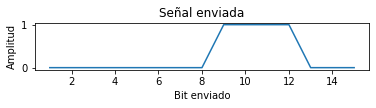

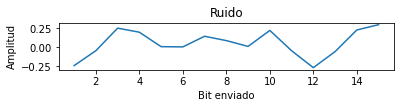

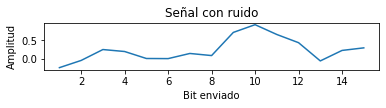

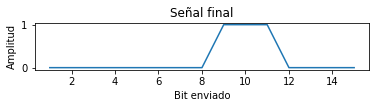

La senal enviada es: [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]

El ruido anadido a la senal es: [-0.2785319   0.00710097 -0.03184941  0.24554635 -0.02229942  0.09860236
 -0.28497893  0.12975541 -0.20054192 -0.18305215 -0.15511908  0.05711659
  0.15755136  0.04919811  0.00320188]

La senal resultante con el ruido es: [-0.2785319   0.00710097 -0.03184941  0.24554635 -0.02229942  0.09860236
 -0.28497893  0.12975541  0.49945808  0.51694785  0.54488092  0.75711659
  0.85755136  0.74919811  0.70320188]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



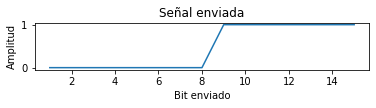

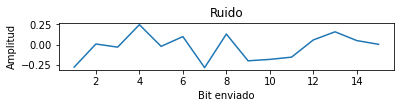

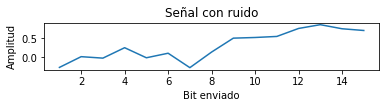

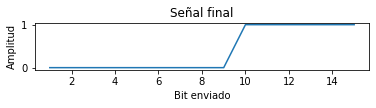

La senal enviada es: [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]

El ruido anadido a la senal es: [ 0.25061707  0.1523131   0.30941246 -0.23988381 -0.02586019  0.09112188
  0.17166931  0.19607019  0.06814943 -0.26038127 -0.09480365 -0.13134942
 -0.03551649  0.0436512   0.17267752]

La senal resultante con el ruido es: [ 0.25061707  0.1523131   0.30941246 -0.23988381 -0.02586019  0.09112188
  0.17166931  0.19607019  0.76814943  0.43961873  0.60519635  0.56865058
  0.66448351  0.7436512   0.87267752]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



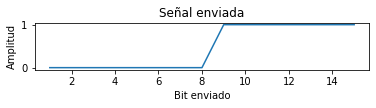

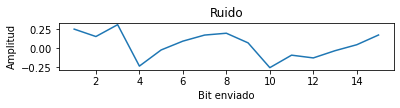

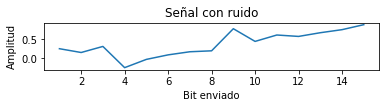

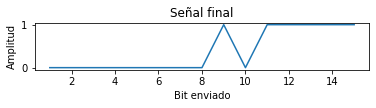

La senal enviada es: [0 0 0 0 0 0 1 1 0 0 0 0 0 0 1]

El ruido anadido a la senal es: [-0.01859144  0.0282946  -0.18494319  0.00863464 -0.04607136  0.13544039
 -0.10737918 -0.03366483  0.27120696 -0.27815956 -0.40647823 -0.00338348
  0.03625884  0.10171793  0.25040521]

La senal resultante con el ruido es: [-0.01859144  0.0282946  -0.18494319  0.00863464 -0.04607136  0.13544039
  0.59262082  0.66633517  0.27120696 -0.27815956 -0.40647823 -0.00338348
  0.03625884  0.10171793  0.95040521]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



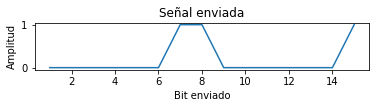

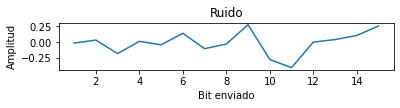

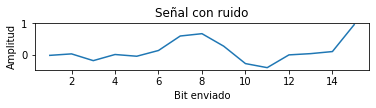

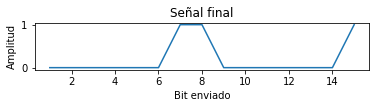

La senal enviada es: [0 0 0 0 0 0 1 1 0 0 0 0 1 1 0]

El ruido anadido a la senal es: [ 0.01511039 -0.00825624 -0.0158225  -0.09087963 -0.08766819 -0.10433216
  0.02403043  0.02253113 -0.09705386  0.06400409  0.09151761 -0.07161975
  0.13878917  0.23118455 -0.10291417]

La senal resultante con el ruido es: [ 0.01511039 -0.00825624 -0.0158225  -0.09087963 -0.08766819 -0.10433216
  0.72403043  0.72253113 -0.09705386  0.06400409  0.09151761 -0.07161975
  0.83878917  0.93118455 -0.10291417]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



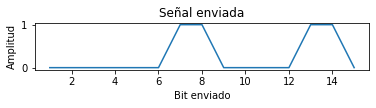

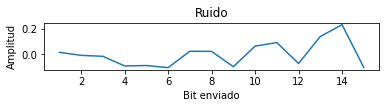

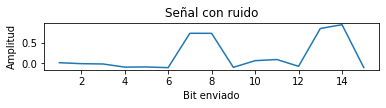

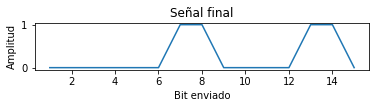

La senal enviada es: [0 0 0 0 0 0 1 1 0 0 1 1 0 0 0]

El ruido anadido a la senal es: [ 0.22671247 -0.27482162 -0.2474604  -0.02638936 -0.01433019 -0.12285691
  0.01068185  0.14517645  0.39022691  0.18032701  0.09398126  0.04765026
 -0.14168511  0.15618653  0.07952514]

La senal resultante con el ruido es: [ 0.22671247 -0.27482162 -0.2474604  -0.02638936 -0.01433019 -0.12285691
  0.71068185  0.84517645  0.39022691  0.18032701  0.79398126  0.74765026
 -0.14168511  0.15618653  0.07952514]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



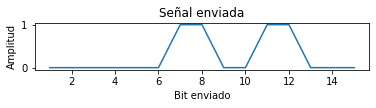

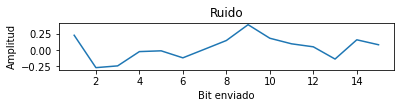

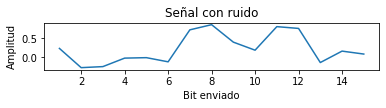

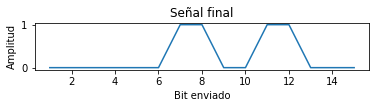

La senal enviada es: [0 0 0 0 0 0 1 1 0 0 1 1 0 0 0]

El ruido anadido a la senal es: [-0.01817941 -0.02596671  0.00444802 -0.09656553 -0.15168264 -0.09504856
 -0.11788823  0.03306646  0.22491128  0.10186328 -0.07884703  0.15868666
 -0.40892862  0.44563311 -0.10865864]

La senal resultante con el ruido es: [-0.01817941 -0.02596671  0.00444802 -0.09656553 -0.15168264 -0.09504856
  0.58211177  0.73306646  0.22491128  0.10186328  0.62115297  0.85868666
 -0.40892862  0.44563311 -0.10865864]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



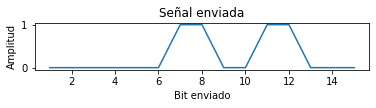

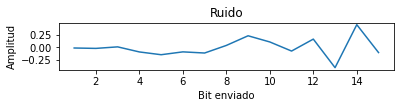

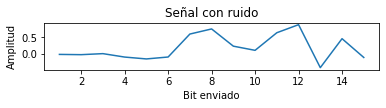

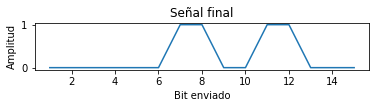

La senal enviada es: [0 0 0 0 0 0 1 1 0 0 1 1 1 1 1]

El ruido anadido a la senal es: [-0.12898899  0.12270806  0.11436388  0.19047648  0.07433569 -0.17807287
  0.24512228  0.12928312  0.03640657  0.14515336  0.26728459  0.14906698
 -0.01216631  0.05617055  0.10748149]

La senal resultante con el ruido es: [-0.12898899  0.12270806  0.11436388  0.19047648  0.07433569 -0.17807287
  0.94512228  0.82928312  0.03640657  0.14515336  0.96728459  0.84906698
  0.68783369  0.75617055  0.80748149]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



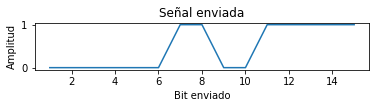

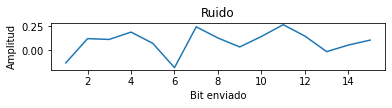

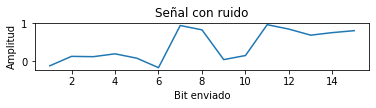

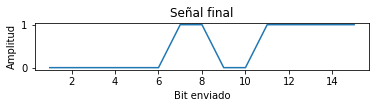

La senal enviada es: [0 0 0 0 0 0 1 1 0 1 0 1 0 1 1]

El ruido anadido a la senal es: [ 0.01424902  0.0121019   0.04521911 -0.05074861 -0.32110664 -0.05068773
  0.0235446  -0.12489893  0.04125244  0.03472582 -0.12887682  0.18508587
 -0.11624229  0.16081518 -0.17544162]

La senal resultante con el ruido es: [ 0.01424902  0.0121019   0.04521911 -0.05074861 -0.32110664 -0.05068773
  0.7235446   0.57510107  0.04125244  0.73472582 -0.12887682  0.88508587
 -0.11624229  0.86081518  0.52455838]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



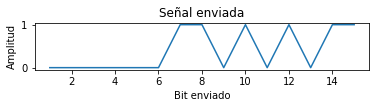

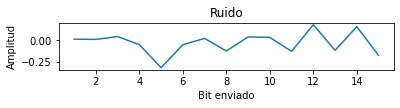

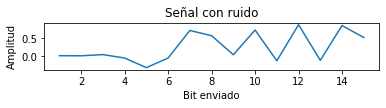

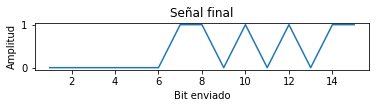

La senal enviada es: [0 0 0 0 0 0 1 1 0 1 0 1 1 0 0]

El ruido anadido a la senal es: [ 0.04218398 -0.21425683  0.16442174  0.13345965 -0.04206186  0.03521534
  0.1076506   0.05041494 -0.05140624  0.07270582  0.2315646   0.16021927
 -0.04865122 -0.24450162  0.28374262]

La senal resultante con el ruido es: [ 0.04218398 -0.21425683  0.16442174  0.13345965 -0.04206186  0.03521534
  0.8076506   0.75041494 -0.05140624  0.77270582  0.2315646   0.86021927
  0.65134878 -0.24450162  0.28374262]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



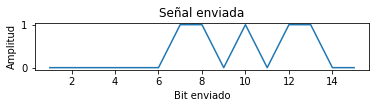

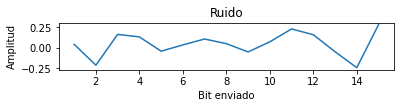

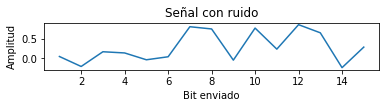

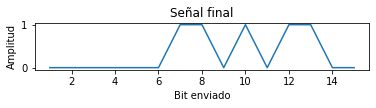

La senal enviada es: [0 0 0 0 0 0 1 1 0 1 0 1 1 0 0]

El ruido anadido a la senal es: [ 0.09277267 -0.08124345  0.06215957  0.11948119 -0.17850609  0.02999917
  0.12867257 -0.23988315  0.13643457  0.17390046 -0.03803104 -0.05233827
  0.13589942 -0.11941009 -0.10758068]

La senal resultante con el ruido es: [ 0.09277267 -0.08124345  0.06215957  0.11948119 -0.17850609  0.02999917
  0.82867257  0.46011685  0.13643457  0.87390046 -0.03803104  0.64766173
  0.83589942 -0.11941009 -0.10758068]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



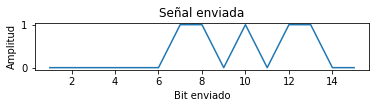

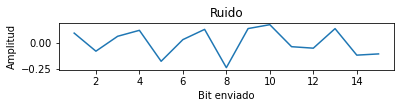

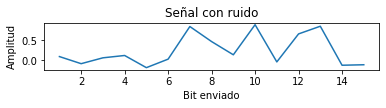

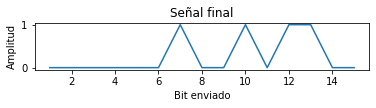

La senal enviada es: [0 0 0 0 0 0 1 1 0 1 1 0 0 1 0]

El ruido anadido a la senal es: [ 0.07780267 -0.19468987 -0.14120285  0.32933238  0.05636249  0.1034131
  0.19853031  0.21653341 -0.38351246  0.31850997  0.18342979 -0.1101673
  0.03235915  0.2999467   0.27137995]

La senal resultante con el ruido es: [ 0.07780267 -0.19468987 -0.14120285  0.32933238  0.05636249  0.1034131
  0.89853031  0.91653341 -0.38351246  1.01850997  0.88342979 -0.1101673
  0.03235915  0.9999467   0.27137995]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



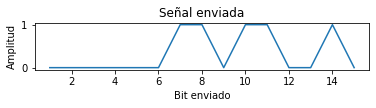

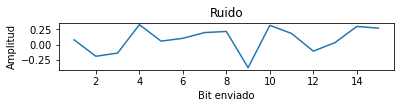

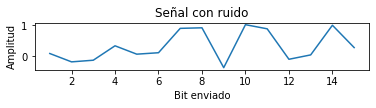

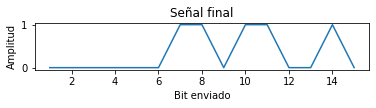

La senal enviada es: [0 0 0 0 0 0 1 1 0 1 1 0 0 1 0]

El ruido anadido a la senal es: [-0.38983301 -0.00728366  0.08460755 -0.13078535  0.06828731 -0.23943663
  0.2006811  -0.07299357 -0.04181878 -0.34699854 -0.02506682  0.00400419
  0.2508833   0.06895916 -0.03853085]

La senal resultante con el ruido es: [-0.38983301 -0.00728366  0.08460755 -0.13078535  0.06828731 -0.23943663
  0.9006811   0.62700643 -0.04181878  0.35300146  0.67493318  0.00400419
  0.2508833   0.76895916 -0.03853085]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



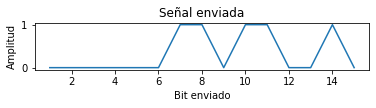

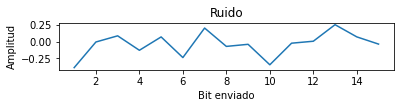

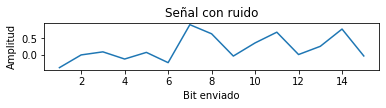

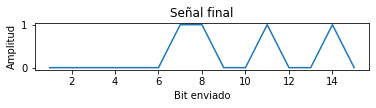

La senal enviada es: [0 0 0 0 0 0 1 1 0 1 1 0 1 0 1]

El ruido anadido a la senal es: [-0.12956827  0.08884675  0.04274107  0.13423963 -0.03543557  0.15542728
  0.20438621 -0.03140024 -0.08538364  0.06304474  0.37410962  0.05319679
  0.19880592 -0.10100242  0.22723679]

La senal resultante con el ruido es: [-0.12956827  0.08884675  0.04274107  0.13423963 -0.03543557  0.15542728
  0.90438621  0.66859976 -0.08538364  0.76304474  1.07410962  0.05319679
  0.89880592 -0.10100242  0.92723679]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



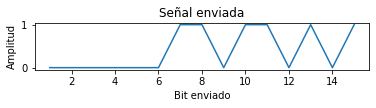

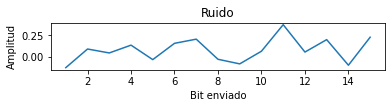

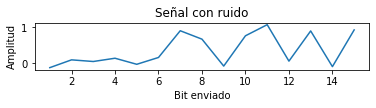

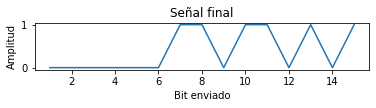

La senal enviada es: [0 0 0 0 0 0 1 1 1 0 0 1 0 1 0]

El ruido anadido a la senal es: [ 0.0484922   0.09948777 -0.41214496 -0.32545719  0.31041614 -0.02177911
 -0.17700772 -0.1483078   0.03161494 -0.01678023  0.07910906  0.0007014
 -0.09874012 -0.14074613 -0.30318639]

La senal resultante con el ruido es: [ 0.0484922   0.09948777 -0.41214496 -0.32545719  0.31041614 -0.02177911
  0.52299228  0.5516922   0.73161494 -0.01678023  0.07910906  0.7007014
 -0.09874012  0.55925387 -0.30318639]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



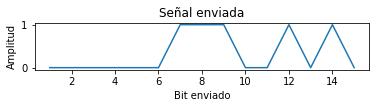

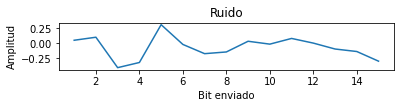

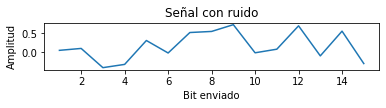

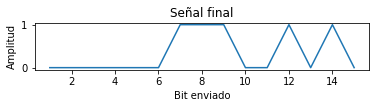

La senal enviada es: [0 0 0 0 0 0 1 1 1 0 0 1 0 1 0]

El ruido anadido a la senal es: [-0.15259998  0.10230942 -0.07463266 -0.00522314  0.16289716  0.30130255
  0.04807203  0.0900755   0.31738665  0.14629725  0.18407084  0.11229863
  0.24497526 -0.31421181  0.02797218]

La senal resultante con el ruido es: [-0.15259998  0.10230942 -0.07463266 -0.00522314  0.16289716  0.30130255
  0.74807203  0.7900755   1.01738665  0.14629725  0.18407084  0.81229863
  0.24497526  0.38578819  0.02797218]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



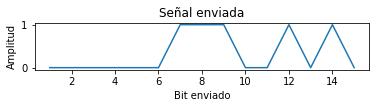

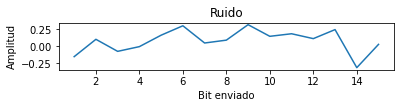

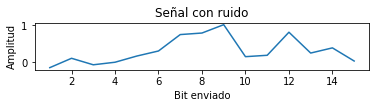

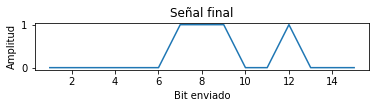

La senal enviada es: [0 0 0 0 0 0 1 1 1 0 0 1 1 0 1]

El ruido anadido a la senal es: [ 0.0312356  -0.09684829  0.06175537 -0.18385124  0.0493626   0.06368616
  0.1658562   0.0603222   0.03415784  0.07030593  0.35903931 -0.32436271
  0.42890003 -0.08635406 -0.04539856]

La senal resultante con el ruido es: [ 0.0312356  -0.09684829  0.06175537 -0.18385124  0.0493626   0.06368616
  0.8658562   0.7603222   0.73415784  0.07030593  0.35903931  0.37563729
  1.12890003 -0.08635406  0.65460144]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



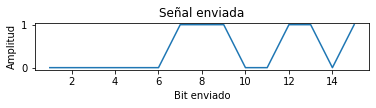

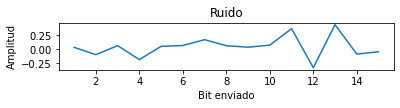

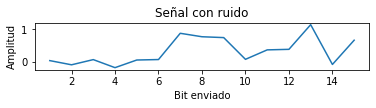

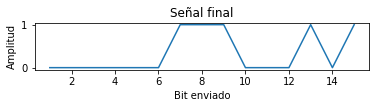

La senal enviada es: [0 0 0 0 0 0 1 1 1 0 0 1 1 0 1]

El ruido anadido a la senal es: [-0.0834615   0.13072725  0.36369723 -0.03776749 -0.04100873 -0.21443632
 -0.02189085  0.00205718 -0.08056592  0.03213212  0.2841601  -0.01570666
  0.3144608   0.15636197  0.26199823]

La senal resultante con el ruido es: [-0.0834615   0.13072725  0.36369723 -0.03776749 -0.04100873 -0.21443632
  0.67810915  0.70205718  0.61943408  0.03213212  0.2841601   0.68429334
  1.0144608   0.15636197  0.96199823]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



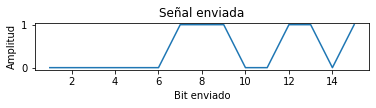

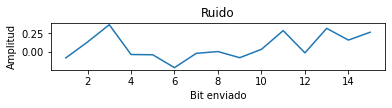

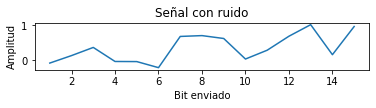

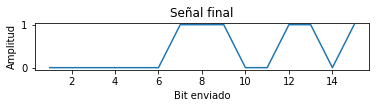

La senal enviada es: [0 0 0 0 0 0 1 1 1 0 1 0 0 1 1]

El ruido anadido a la senal es: [-0.16415659  0.17794531  0.25085497  0.04420471 -0.13994442 -0.07637046
 -0.14756795 -0.1262662   0.18803037  0.09079678  0.01252095 -0.34171556
  0.04100346 -0.09648335  0.1194864 ]

La senal resultante con el ruido es: [-0.16415659  0.17794531  0.25085497  0.04420471 -0.13994442 -0.07637046
  0.55243205  0.5737338   0.88803037  0.09079678  0.71252095 -0.34171556
  0.04100346  0.60351665  0.8194864 ]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



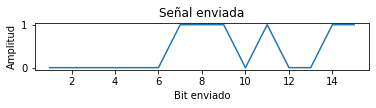

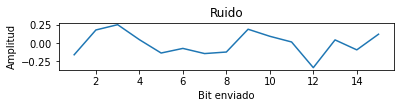

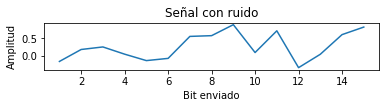

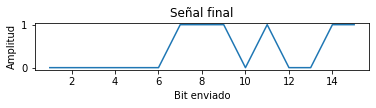

La senal enviada es: [0 0 0 0 0 0 1 1 1 0 1 0 1 0 0]

El ruido anadido a la senal es: [ 0.03175774  0.12092761 -0.00096293 -0.05280511  0.07064571 -0.19564358
  0.05029004  0.2256931   0.21001465 -0.05603572  0.20326948 -0.04770183
 -0.06631665 -0.18128177 -0.12729122]

La senal resultante con el ruido es: [ 0.03175774  0.12092761 -0.00096293 -0.05280511  0.07064571 -0.19564358
  0.75029004  0.9256931   0.91001465 -0.05603572  0.90326948 -0.04770183
  0.63368335 -0.18128177 -0.12729122]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



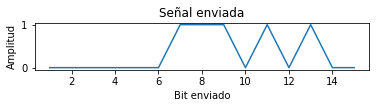

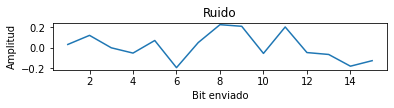

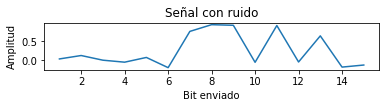

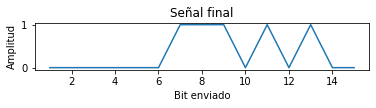

La senal enviada es: [0 0 0 0 0 0 1 1 1 1 0 0 0 0 0]

El ruido anadido a la senal es: [-0.04631167 -0.27814272 -0.04233892  0.03414345 -0.17083009  0.17534145
  0.07999462  0.23300892 -0.0272301  -0.09646677  0.10177231 -0.32002268
  0.03077698  0.23089137 -0.26397621]

La senal resultante con el ruido es: [-0.04631167 -0.27814272 -0.04233892  0.03414345 -0.17083009  0.17534145
  0.77999462  0.93300892  0.6727699   0.60353323  0.10177231 -0.32002268
  0.03077698  0.23089137 -0.26397621]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



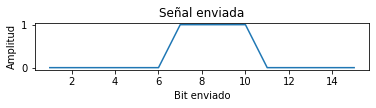

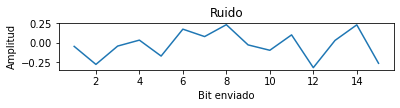

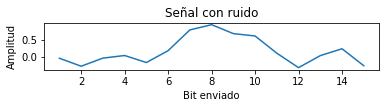

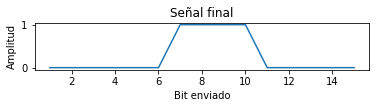

La senal enviada es: [0 0 0 0 0 0 1 1 1 1 0 0 1 1 1]

El ruido anadido a la senal es: [ 0.15025644  0.34333568  0.20683351  0.14410345  0.19871596 -0.08125291
  0.12058612  0.11602449 -0.26558182 -0.20979422 -0.15830808 -0.0326602
  0.32253181 -0.07453211  0.19088073]

La senal resultante con el ruido es: [ 0.15025644  0.34333568  0.20683351  0.14410345  0.19871596 -0.08125291
  0.82058612  0.81602449  0.43441818  0.49020578 -0.15830808 -0.0326602
  1.02253181  0.62546789  0.89088073]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



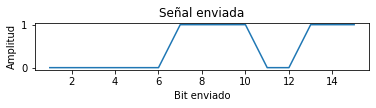

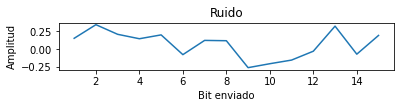

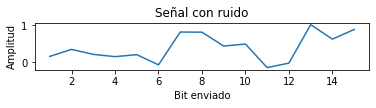

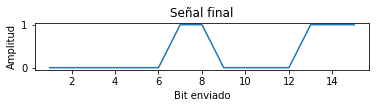

La senal enviada es: [0 0 0 0 0 0 1 1 1 1 1 1 0 0 1]

El ruido anadido a la senal es: [ 0.15335055  0.06456363 -0.20390835 -0.28374229  0.02886475  0.1037731
 -0.19403895 -0.34630401 -0.03406696  0.29908487 -0.22564818 -0.10591775
 -0.01698464  0.25058217  0.00079839]

La senal resultante con el ruido es: [ 0.15335055  0.06456363 -0.20390835 -0.28374229  0.02886475  0.1037731
  0.50596105  0.35369599  0.66593304  0.99908487  0.47435182  0.59408225
 -0.01698464  0.25058217  0.70079839]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



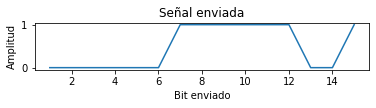

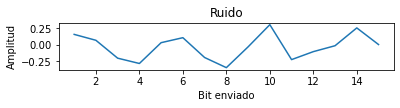

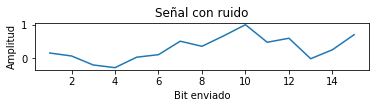

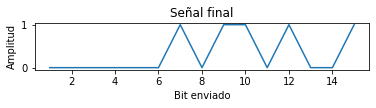

La senal enviada es: [0 0 0 0 0 0 1 1 1 1 1 1 0 0 1]

El ruido anadido a la senal es: [ 0.25905437  0.14358385  0.00758769 -0.11822992  0.03363777 -0.03471858
 -0.10151959  0.2441905   0.30077654  0.3196865   0.280816    0.12601972
  0.08992386 -0.12909084  0.1043971 ]

La senal resultante con el ruido es: [ 0.25905437  0.14358385  0.00758769 -0.11822992  0.03363777 -0.03471858
  0.59848041  0.9441905   1.00077654  1.0196865   0.980816    0.82601972
  0.08992386 -0.12909084  0.8043971 ]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



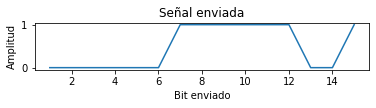

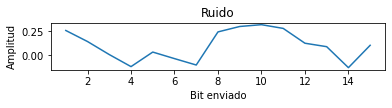

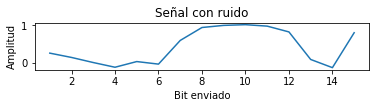

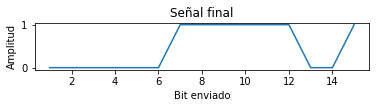

La senal enviada es: [0 0 0 0 0 0 1 1 1 1 1 1 1 1 0]

El ruido anadido a la senal es: [ 0.34023758 -0.23615565  0.13879547 -0.00467702  0.18199462  0.15611751
 -0.08094064  0.3582     -0.15062253 -0.10890731 -0.09256457 -0.21236323
  0.10363932 -0.03712522 -0.09026412]

La senal resultante con el ruido es: [ 0.34023758 -0.23615565  0.13879547 -0.00467702  0.18199462  0.15611751
  0.61905936  1.0582      0.54937747  0.59109269  0.60743543  0.48763677
  0.80363932  0.66287478 -0.09026412]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



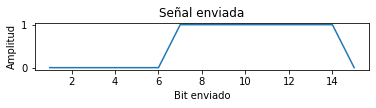

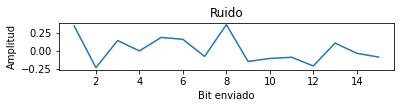

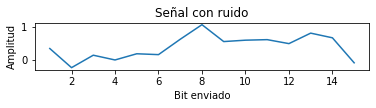

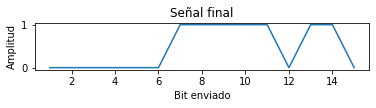

La senal enviada es: [0 0 0 0 0 1 0 1 0 0 0 0 0 1 0]

El ruido anadido a la senal es: [-0.18256612  0.08588537 -0.23244551  0.04868056 -0.27944123 -0.16197714
 -0.0173323  -0.00608209  0.29418272 -0.15103589 -0.00798358 -0.04444056
  0.24377282  0.0225839   0.15665832]

La senal resultante con el ruido es: [-0.18256612  0.08588537 -0.23244551  0.04868056 -0.27944123  0.53802286
 -0.0173323   0.69391791  0.29418272 -0.15103589 -0.00798358 -0.04444056
  0.24377282  0.7225839   0.15665832]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



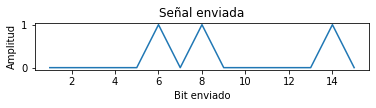

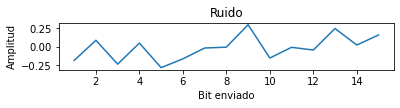

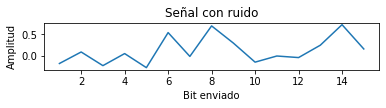

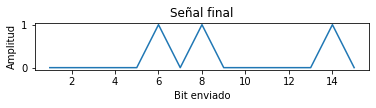

La senal enviada es: [0 0 0 0 0 1 0 1 0 0 0 0 0 1 0]

El ruido anadido a la senal es: [ 0.17280301 -0.15127599 -0.26312184 -0.03481411  0.03359187 -0.21226963
  0.1822124   0.1552278   0.12412647 -0.08592198 -0.09905525 -0.07306085
  0.00270636 -0.18676636 -0.37441148]

La senal resultante con el ruido es: [ 0.17280301 -0.15127599 -0.26312184 -0.03481411  0.03359187  0.48773037
  0.1822124   0.8552278   0.12412647 -0.08592198 -0.09905525 -0.07306085
  0.00270636  0.51323364 -0.37441148]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



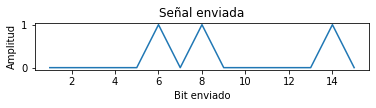

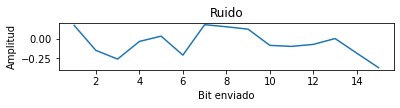

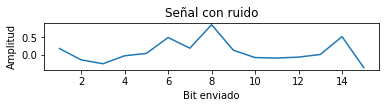

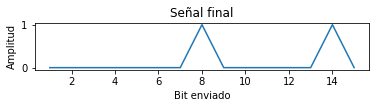

La senal enviada es: [0 0 0 0 0 1 0 1 0 0 0 0 1 0 1]

El ruido anadido a la senal es: [-0.26733518  0.16302893  0.0383368  -0.01523557  0.04965893 -0.02754904
 -0.09392028  0.19572883  0.07069221  0.44316845  0.13926394  0.01696476
 -0.09802948 -0.11931302  0.01885004]

La senal resultante con el ruido es: [-0.26733518  0.16302893  0.0383368  -0.01523557  0.04965893  0.67245096
 -0.09392028  0.89572883  0.07069221  0.44316845  0.13926394  0.01696476
  0.60197052 -0.11931302  0.71885004]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



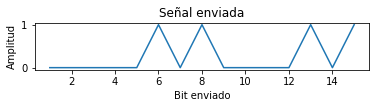

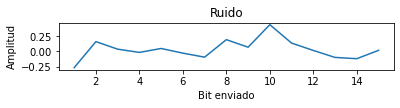

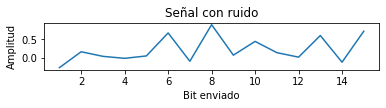

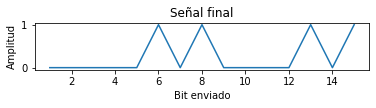

La senal enviada es: [0 0 0 0 0 1 0 1 0 0 0 0 1 0 1]

El ruido anadido a la senal es: [-0.05466699  0.02688783  0.25583254 -0.0915592   0.14655011  0.12545072
  0.13800943  0.21699346 -0.16005709  0.0168409   0.23850245  0.08722674
  0.05923639  0.18641347  0.11845814]

La senal resultante con el ruido es: [-0.05466699  0.02688783  0.25583254 -0.0915592   0.14655011  0.82545072
  0.13800943  0.91699346 -0.16005709  0.0168409   0.23850245  0.08722674
  0.75923639  0.18641347  0.81845814]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



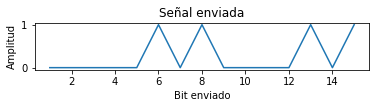

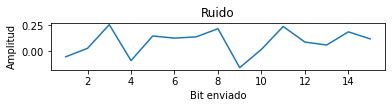

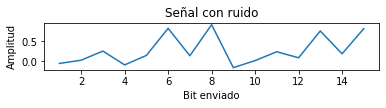

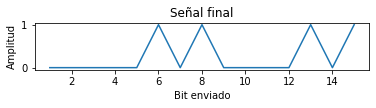

La senal enviada es: [0 0 0 0 0 1 0 1 0 0 0 0 1 0 1]

El ruido anadido a la senal es: [-0.20672696 -0.08840824 -0.0761776  -0.2080971  -0.03451491  0.10574223
  0.08100482  0.07310452  0.01651375 -0.04292862 -0.22651105  0.13216721
  0.26446345  0.09930554  0.11325007]

La senal resultante con el ruido es: [-0.20672696 -0.08840824 -0.0761776  -0.2080971  -0.03451491  0.80574223
  0.08100482  0.77310452  0.01651375 -0.04292862 -0.22651105  0.13216721
  0.96446345  0.09930554  0.81325007]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



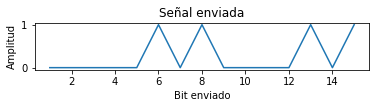

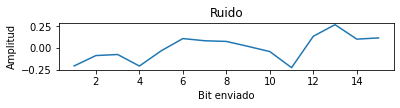

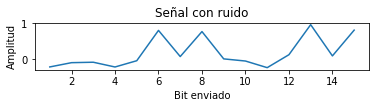

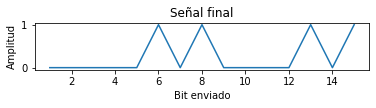

La senal enviada es: [0 0 0 0 0 1 0 1 0 0 1 1 0 1 1]

El ruido anadido a la senal es: [-0.24076721  0.12576311  0.03900843 -0.11968907 -0.18519972 -0.10709655
  0.21081685  0.14262448  0.19765829 -0.04921613 -0.06706017 -0.00143806
 -0.14383365  0.23866984 -0.00664038]

La senal resultante con el ruido es: [-0.24076721  0.12576311  0.03900843 -0.11968907 -0.18519972  0.59290345
  0.21081685  0.84262448  0.19765829 -0.04921613  0.63293983  0.69856194
 -0.14383365  0.93866984  0.69335962]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



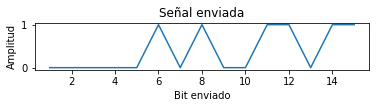

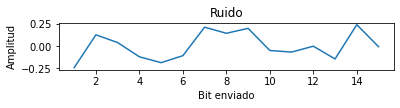

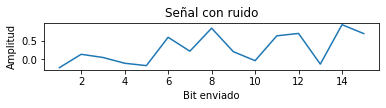

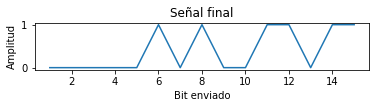

La senal enviada es: [0 0 0 0 0 1 0 1 0 0 1 1 0 1 1]

El ruido anadido a la senal es: [-0.05549628  0.03101493  0.01051626  0.09463291 -0.12987717  0.13747258
 -0.03492094 -0.28554057 -0.05116255  0.08155668  0.08752644  0.1115624
  0.10773906 -0.18883246 -0.0613622 ]

La senal resultante con el ruido es: [-0.05549628  0.03101493  0.01051626  0.09463291 -0.12987717  0.83747258
 -0.03492094  0.41445943 -0.05116255  0.08155668  0.78752644  0.8115624
  0.10773906  0.51116754  0.6386378 ]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



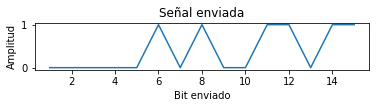

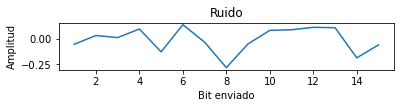

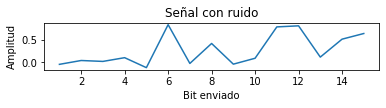

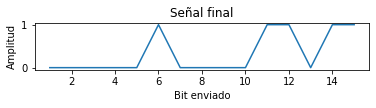

La senal enviada es: [0 0 0 0 0 1 0 1 0 0 1 1 1 0 0]

El ruido anadido a la senal es: [-0.26600411  0.18552076 -0.04144696 -0.19301481  0.02682247  0.22791527
 -0.26362153  0.00053103 -0.02042364 -0.14462148 -0.367231    0.37875281
 -0.01988612 -0.03840807 -0.16023751]

La senal resultante con el ruido es: [-0.26600411  0.18552076 -0.04144696 -0.19301481  0.02682247  0.92791527
 -0.26362153  0.70053103 -0.02042364 -0.14462148  0.332769    1.07875281
  0.68011388 -0.03840807 -0.16023751]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



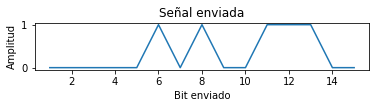

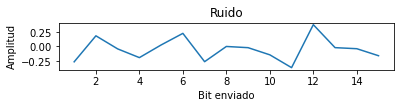

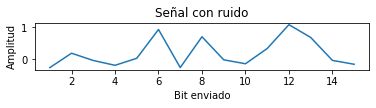

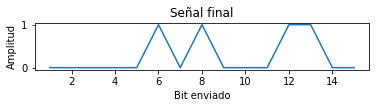

La senal enviada es: [0 0 0 0 0 1 0 1 0 0 1 1 1 0 0]

El ruido anadido a la senal es: [-0.24779801 -0.34752402 -0.1993506   0.00197279  0.20592129  0.02516653
 -0.1371731   0.13495312  0.1051769  -0.08051939 -0.27563275  0.18849454
 -0.4288864   0.32432522  0.08234783]

La senal resultante con el ruido es: [-0.24779801 -0.34752402 -0.1993506   0.00197279  0.20592129  0.72516653
 -0.1371731   0.83495312  0.1051769  -0.08051939  0.42436725  0.88849454
  0.2711136   0.32432522  0.08234783]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



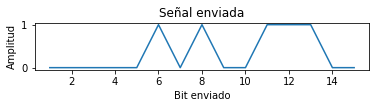

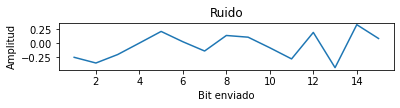

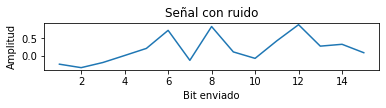

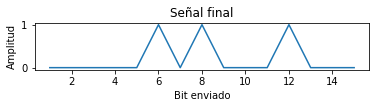

La senal enviada es: [0 0 0 0 0 1 0 1 0 1 0 1 0 0 0]

El ruido anadido a la senal es: [-0.24288953 -0.15206406  0.04405784 -0.14596776  0.12989082  0.07690363
  0.08049623  0.05086196 -0.10527157 -0.06253292 -0.12911427 -0.02740908
  0.219496   -0.08144622 -0.23333345]

La senal resultante con el ruido es: [-0.24288953 -0.15206406  0.04405784 -0.14596776  0.12989082  0.77690363
  0.08049623  0.75086196 -0.10527157  0.63746708 -0.12911427  0.67259092
  0.219496   -0.08144622 -0.23333345]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



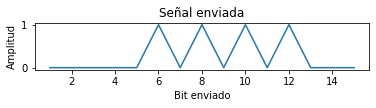

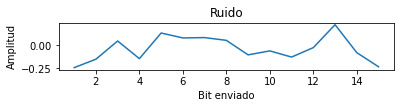

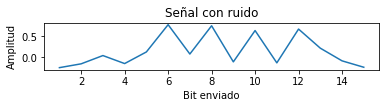

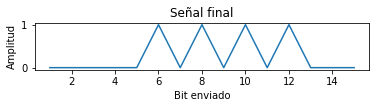

La senal enviada es: [0 0 0 0 0 1 0 1 0 1 0 1 1 1 1]

El ruido anadido a la senal es: [ 0.11636414 -0.18280582 -0.23663846 -0.131198   -0.00991647 -0.16933633
  0.15094091  0.04099275 -0.04916231 -0.20578308  0.42974399  0.27268839
  0.06475248  0.20199616  0.03791495]

La senal resultante con el ruido es: [ 0.11636414 -0.18280582 -0.23663846 -0.131198   -0.00991647  0.53066367
  0.15094091  0.74099275 -0.04916231  0.49421692  0.42974399  0.97268839
  0.76475248  0.90199616  0.73791495]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



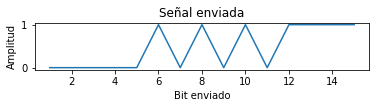

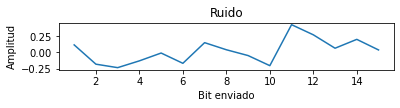

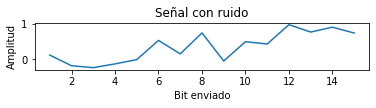

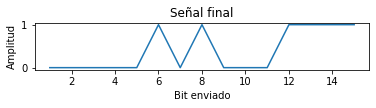

La senal enviada es: [0 0 0 0 0 1 0 1 0 1 0 1 1 1 1]

El ruido anadido a la senal es: [ 0.11626328  0.07052868 -0.23305857  0.15144887  0.21513585  0.1528757
 -0.10001392  0.18793586  0.07221082 -0.17017804 -0.06772869  0.08791374
  0.07985003  0.07783659  0.03993446]

La senal resultante con el ruido es: [ 0.11626328  0.07052868 -0.23305857  0.15144887  0.21513585  0.8528757
 -0.10001392  0.88793586  0.07221082  0.52982196 -0.06772869  0.78791374
  0.77985003  0.77783659  0.73993446]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



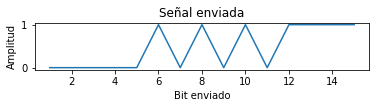

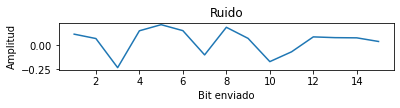

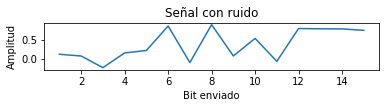

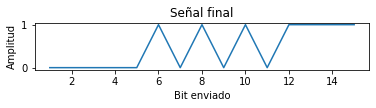

La senal enviada es: [0 0 0 0 0 1 0 1 0 1 1 0 0 0 1]

El ruido anadido a la senal es: [ 0.23431309 -0.25461261 -0.19034264  0.19408754 -0.1684389  -0.23231104
 -0.0926537   0.09699034  0.38495813  0.358136   -0.09672158  0.1944818
 -0.05634565 -0.12025364 -0.01265472]

La senal resultante con el ruido es: [ 0.23431309 -0.25461261 -0.19034264  0.19408754 -0.1684389   0.46768896
 -0.0926537   0.79699034  0.38495813  1.058136    0.60327842  0.1944818
 -0.05634565 -0.12025364  0.68734528]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



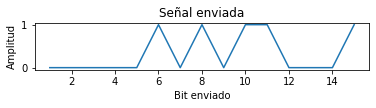

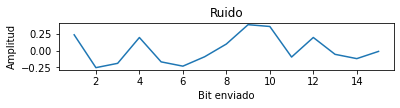

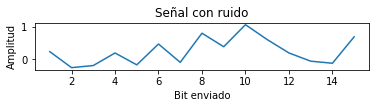

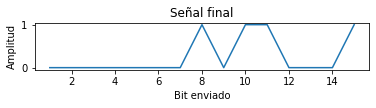

La senal enviada es: [0 0 0 0 0 1 0 1 0 1 1 0 1 1 0]

El ruido anadido a la senal es: [-0.13897501  0.33304393 -0.1371613   0.01203759  0.01661153  0.06498567
  0.11227182  0.03347511 -0.10406696  0.12508576  0.19400534  0.03195308
 -0.10578693  0.09644631  0.08369696]

La senal resultante con el ruido es: [-0.13897501  0.33304393 -0.1371613   0.01203759  0.01661153  0.76498567
  0.11227182  0.73347511 -0.10406696  0.82508576  0.89400534  0.03195308
  0.59421307  0.79644631  0.08369696]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



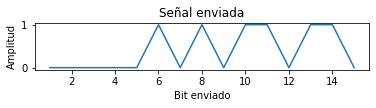

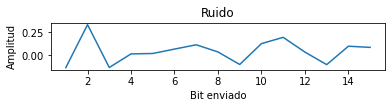

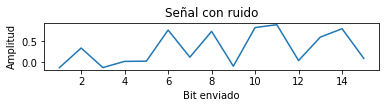

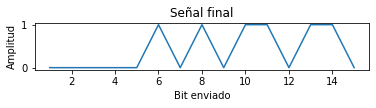

La senal enviada es: [0 0 0 0 0 1 0 1 1 0 0 1 0 0 1]

El ruido anadido a la senal es: [-0.43469392 -0.17323861  0.11635016  0.0418855   0.03666925 -0.1232355
  0.10806048  0.24556831  0.04413157 -0.02211986  0.18249053  0.05086437
 -0.0702435  -0.1231705  -0.18430525]

La senal resultante con el ruido es: [-0.43469392 -0.17323861  0.11635016  0.0418855   0.03666925  0.5767645
  0.10806048  0.94556831  0.74413157 -0.02211986  0.18249053  0.75086437
 -0.0702435  -0.1231705   0.51569475]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



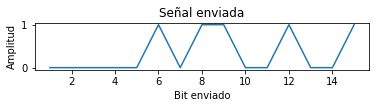

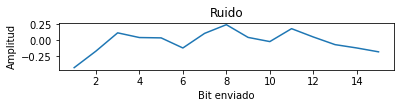

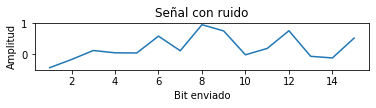

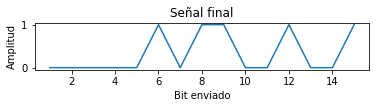

La senal enviada es: [0 0 0 0 0 1 0 1 1 0 0 1 0 0 1]

El ruido anadido a la senal es: [ 0.02891744 -0.00191107  0.08753969 -0.19293815 -0.09593944 -0.31168065
  0.06928045 -0.03918792  0.22571373 -0.0538871   0.07856886 -0.09216571
  0.05503816  0.09321147  0.00713885]

La senal resultante con el ruido es: [ 0.02891744 -0.00191107  0.08753969 -0.19293815 -0.09593944  0.38831935
  0.06928045  0.66081208  0.92571373 -0.0538871   0.07856886  0.60783429
  0.05503816  0.09321147  0.70713885]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



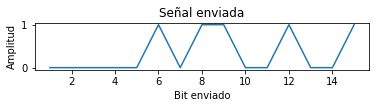

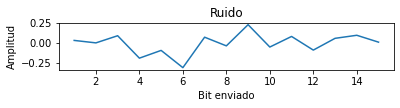

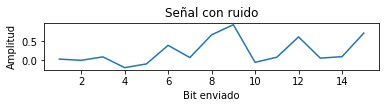

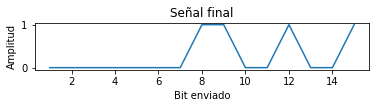

La senal enviada es: [0 0 0 0 0 1 0 1 1 0 0 1 1 1 0]

El ruido anadido a la senal es: [ 0.11619389 -0.21311248 -0.09354933 -0.0624082   0.13323964 -0.07412657
 -0.23327814 -0.05077708 -0.0156775  -0.01368526 -0.1437655  -0.13306208
 -0.13671881 -0.31428313 -0.09537594]

La senal resultante con el ruido es: [ 0.11619389 -0.21311248 -0.09354933 -0.0624082   0.13323964  0.62587343
 -0.23327814  0.64922292  0.6843225  -0.01368526 -0.1437655   0.56693792
  0.56328119  0.38571687 -0.09537594]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



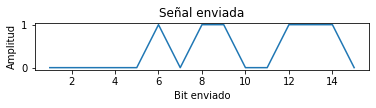

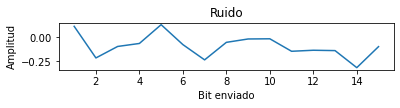

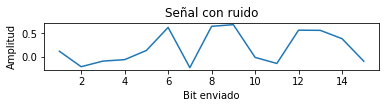

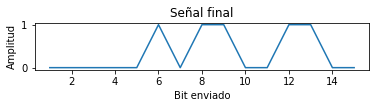

La senal enviada es: [0 0 0 0 0 1 0 1 1 0 1 0 0 0 0]

El ruido anadido a la senal es: [-0.12602646  0.19956191 -0.15219122  0.15444621  0.46934992 -0.07333706
 -0.19503324 -0.10351227 -0.00484696  0.01899758 -0.13317297 -0.00150841
  0.17833135  0.05828423  0.1876603 ]

La senal resultante con el ruido es: [-0.12602646  0.19956191 -0.15219122  0.15444621  0.46934992  0.62666294
 -0.19503324  0.59648773  0.69515304  0.01899758  0.56682703 -0.00150841
  0.17833135  0.05828423  0.1876603 ]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



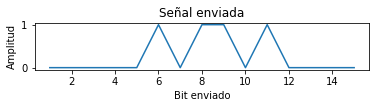

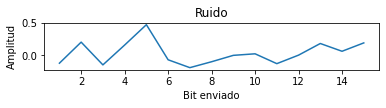

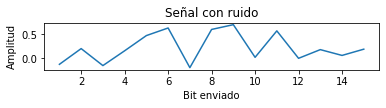

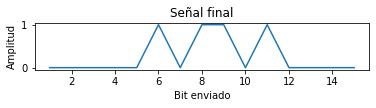

La senal enviada es: [0 0 0 0 0 1 0 1 1 0 1 0 1 1 1]

El ruido anadido a la senal es: [ 0.07256922  0.13168073  0.08282035  0.31429908 -0.18110131  0.15906145
  0.00116354  0.01134794  0.03178896  0.07179995 -0.18984846 -0.13769074
  0.17508188  0.15996681  0.01651807]

La senal resultante con el ruido es: [ 0.07256922  0.13168073  0.08282035  0.31429908 -0.18110131  0.85906145
  0.00116354  0.71134794  0.73178896  0.07179995  0.51015154 -0.13769074
  0.87508188  0.85996681  0.71651807]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



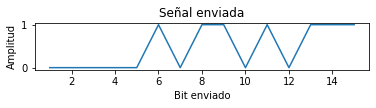

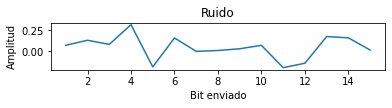

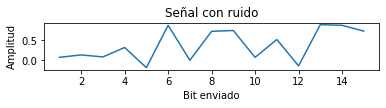

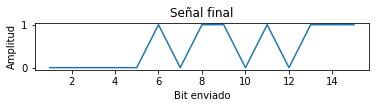

La senal enviada es: [0 0 0 0 0 1 0 1 1 1 0 0 1 0 0]

El ruido anadido a la senal es: [ 0.15734741 -0.1051325   0.11293869 -0.11212612 -0.06839652  0.04378184
 -0.16601719  0.16964258 -0.23483217 -0.04702833 -0.16788325  0.23243208
  0.22546512  0.23826969  0.12941446]

La senal resultante con el ruido es: [ 0.15734741 -0.1051325   0.11293869 -0.11212612 -0.06839652  0.74378184
 -0.16601719  0.86964258  0.46516783  0.65297167 -0.16788325  0.23243208
  0.92546512  0.23826969  0.12941446]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



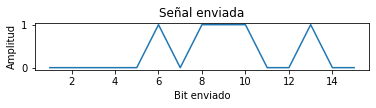

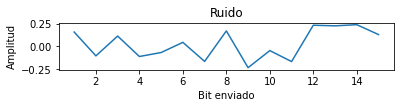

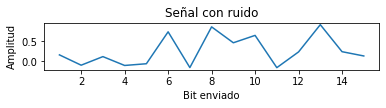

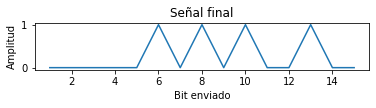

La senal enviada es: [0 0 0 0 0 1 0 1 1 1 0 0 1 0 0]

El ruido anadido a la senal es: [ 0.08943706 -0.11828241  0.21948997  0.22154917  0.16153172 -0.03058767
 -0.16987366  0.0475763  -0.11503174  0.09366132 -0.06877864  0.03240105
 -0.01413815 -0.06281808  0.12815078]

La senal resultante con el ruido es: [ 0.08943706 -0.11828241  0.21948997  0.22154917  0.16153172  0.66941233
 -0.16987366  0.7475763   0.58496826  0.79366132 -0.06877864  0.03240105
  0.68586185 -0.06281808  0.12815078]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



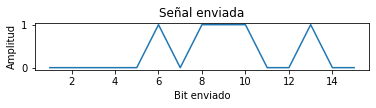

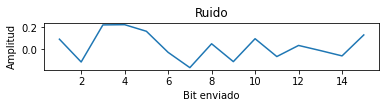

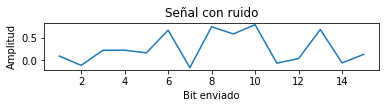

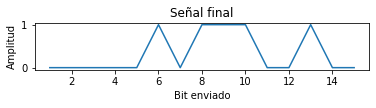

La senal enviada es: [0 0 0 0 0 1 0 1 1 1 1 1 1 0 1]

El ruido anadido a la senal es: [ 0.01721535  0.20344316 -0.11550906  0.125      -0.16545094  0.18656613
 -0.12301067 -0.39131021  0.29169094  0.08415464 -0.06384424  0.04495715
 -0.12873099  0.20730294 -0.1539434 ]

La senal resultante con el ruido es: [ 0.01721535  0.20344316 -0.11550906  0.125      -0.16545094  0.88656613
 -0.12301067  0.30868979  0.99169094  0.78415464  0.63615576  0.74495715
  0.57126901  0.20730294  0.5460566 ]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



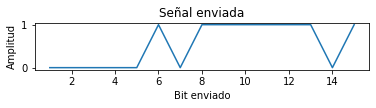

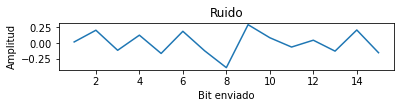

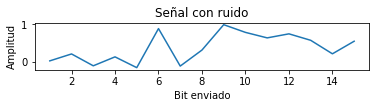

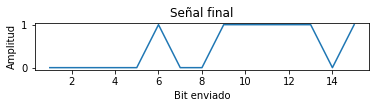

La senal enviada es: [0 0 0 0 0 1 1 0 0 0 0 0 0 1 1]

El ruido anadido a la senal es: [ 0.17933774  0.27223451 -0.06138416  0.31497657  0.17149303  0.10269358
 -0.00806657  0.02510675  0.19432526 -0.25377586 -0.23557591  0.15228542
 -0.02225722 -0.12895464  0.11616615]

La senal resultante con el ruido es: [ 0.17933774  0.27223451 -0.06138416  0.31497657  0.17149303  0.80269358
  0.69193343  0.02510675  0.19432526 -0.25377586 -0.23557591  0.15228542
 -0.02225722  0.57104536  0.81616615]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



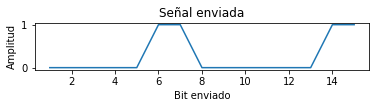

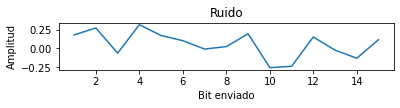

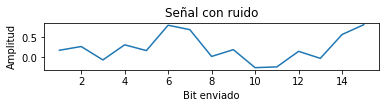

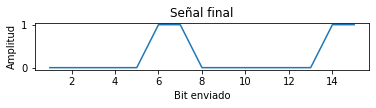

La senal enviada es: [0 0 0 0 0 1 1 0 0 0 0 0 1 0 0]

El ruido anadido a la senal es: [-0.40176472  0.0474412   0.14704698 -0.24366338  0.11660817  0.25063472
  0.03761581 -0.00867403 -0.20218074 -0.02626035  0.04163199  0.05670779
 -0.01714054  0.1715663  -0.10472831]

La senal resultante con el ruido es: [-0.40176472  0.0474412   0.14704698 -0.24366338  0.11660817  0.95063472
  0.73761581 -0.00867403 -0.20218074 -0.02626035  0.04163199  0.05670779
  0.68285946  0.1715663  -0.10472831]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



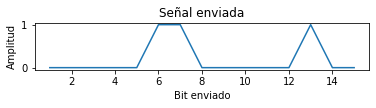

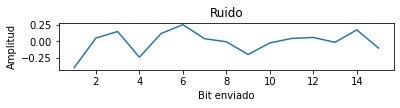

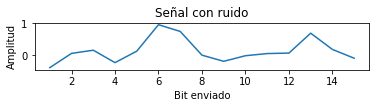

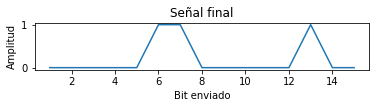

La senal enviada es: [0 0 0 0 0 1 1 0 0 0 1 1 0 1 0]

El ruido anadido a la senal es: [-0.22376743  0.03364702  0.00227437  0.27223069 -0.02610301  0.07617617
  0.02264001 -0.18443921  0.21277411  0.07000052 -0.29706079 -0.11402682
  0.00682014  0.0303189   0.1400814 ]

La senal resultante con el ruido es: [-0.22376743  0.03364702  0.00227437  0.27223069 -0.02610301  0.77617617
  0.72264001 -0.18443921  0.21277411  0.07000052  0.40293921  0.58597318
  0.00682014  0.7303189   0.1400814 ]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



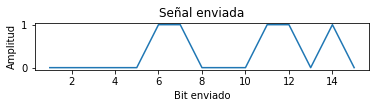

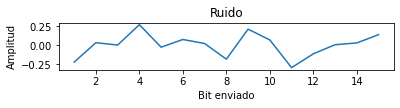

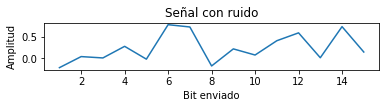

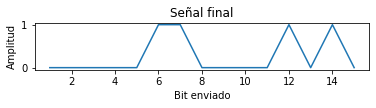

La senal enviada es: [0 0 0 0 0 1 1 0 0 0 1 1 1 0 1]

El ruido anadido a la senal es: [-0.15837514  0.01450896  0.22242066 -0.1554028   0.12564221 -0.1400189
 -0.03560599  0.03321865  0.04603414 -0.15455322 -0.23591821  0.07476694
 -0.22401396  0.00881882  0.04565969]

La senal resultante con el ruido es: [-0.15837514  0.01450896  0.22242066 -0.1554028   0.12564221  0.5599811
  0.66439401  0.03321865  0.04603414 -0.15455322  0.46408179  0.77476694
  0.47598604  0.00881882  0.74565969]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



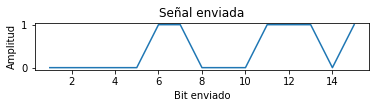

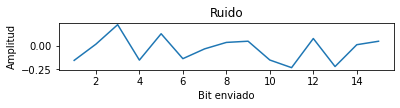

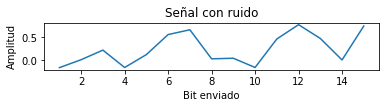

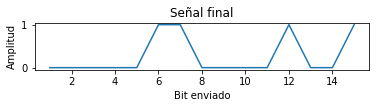

La senal enviada es: [0 0 0 0 0 1 1 0 0 1 0 1 0 0 1]

El ruido anadido a la senal es: [ 0.15439894  0.27994524  0.03721121  0.04674529  0.17863968  0.0360235
  0.0109589   0.0645068  -0.13793466  0.02430981  0.10650386 -0.10508843
  0.06596735  0.08796266  0.25808365]

La senal resultante con el ruido es: [ 0.15439894  0.27994524  0.03721121  0.04674529  0.17863968  0.7360235
  0.7109589   0.0645068  -0.13793466  0.72430981  0.10650386  0.59491157
  0.06596735  0.08796266  0.95808365]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



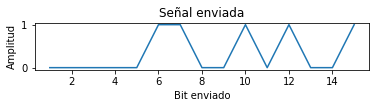

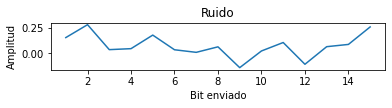

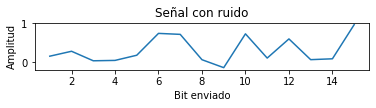

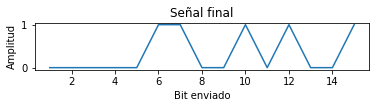

La senal enviada es: [0 0 0 0 0 1 1 0 0 1 0 1 1 1 0]

El ruido anadido a la senal es: [ 0.14139036 -0.11920486  0.02943414 -0.05884752  0.03627276 -0.06157703
  0.17787409  0.26154147  0.06438673  0.02353532 -0.08132367  0.01770154
  0.11585239 -0.07354157 -0.08855634]

La senal resultante con el ruido es: [ 0.14139036 -0.11920486  0.02943414 -0.05884752  0.03627276  0.63842297
  0.87787409  0.26154147  0.06438673  0.72353532 -0.08132367  0.71770154
  0.81585239  0.62645843 -0.08855634]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



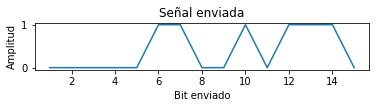

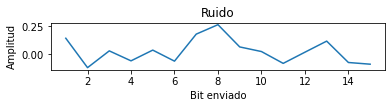

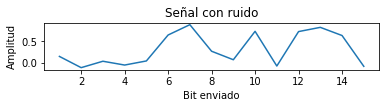

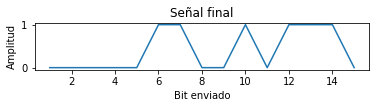

La senal enviada es: [0 0 0 0 0 1 1 0 0 1 1 0 0 0 0]

El ruido anadido a la senal es: [-0.28338611 -0.07460003 -0.19598661  0.00927464  0.07544375  0.12740127
 -0.08613063  0.10882508 -0.05429403 -0.11487225  0.19893711 -0.02744743
 -0.14968251 -0.05933774 -0.01121526]

La senal resultante con el ruido es: [-0.28338611 -0.07460003 -0.19598661  0.00927464  0.07544375  0.82740127
  0.61386937  0.10882508 -0.05429403  0.58512775  0.89893711 -0.02744743
 -0.14968251 -0.05933774 -0.01121526]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



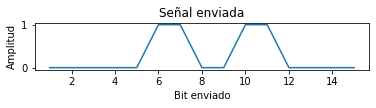

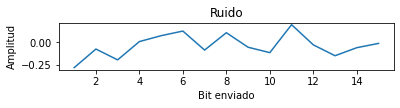

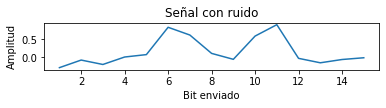

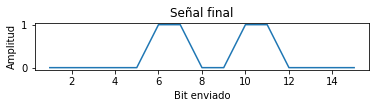

La senal enviada es: [0 0 0 0 0 1 1 0 0 1 1 0 1 1 1]

El ruido anadido a la senal es: [-0.03275379 -0.19285071 -0.1540871   0.02981477  0.34124893  0.23434976
  0.05771882 -0.03603385 -0.04431288  0.31815592  0.00622102  0.13805072
 -0.08543222 -0.03037535  0.17763413]

La senal resultante con el ruido es: [-0.03275379 -0.19285071 -0.1540871   0.02981477  0.34124893  0.93434976
  0.75771882 -0.03603385 -0.04431288  1.01815592  0.70622102  0.13805072
  0.61456778  0.66962465  0.87763413]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



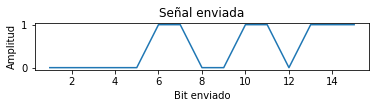

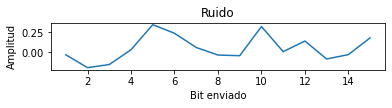

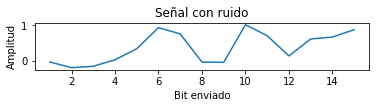

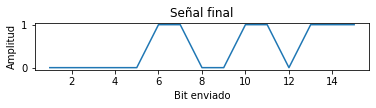

La senal enviada es: [0 0 0 0 0 1 1 0 1 0 0 1 0 0 0]

El ruido anadido a la senal es: [-0.05848381 -0.00657788  0.07143105  0.15585623 -0.06350834 -0.07627348
  0.22399978 -0.36310427 -0.29680841  0.22216963  0.21346765  0.02351819
  0.18264942  0.37869351 -0.14712084]

La senal resultante con el ruido es: [-0.05848381 -0.00657788  0.07143105  0.15585623 -0.06350834  0.62372652
  0.92399978 -0.36310427  0.40319159  0.22216963  0.21346765  0.72351819
  0.18264942  0.37869351 -0.14712084]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



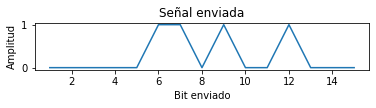

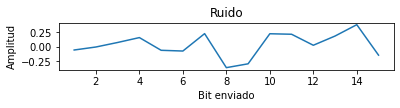

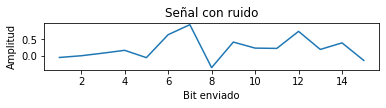

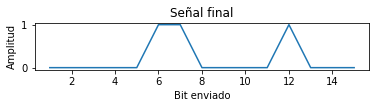

La senal enviada es: [0 0 0 0 0 1 1 0 1 0 0 1 1 1 1]

El ruido anadido a la senal es: [ 0.21503949 -0.10570179  0.03566505 -0.16727843  0.0476127  -0.13407342
  0.05268404 -0.14538329 -0.15868848 -0.19192207  0.03630179  0.0210114
  0.03825762 -0.03752474 -0.06604049]

La senal resultante con el ruido es: [ 0.21503949 -0.10570179  0.03566505 -0.16727843  0.0476127   0.56592658
  0.75268404 -0.14538329  0.54131152 -0.19192207  0.03630179  0.7210114
  0.73825762  0.66247526  0.63395951]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



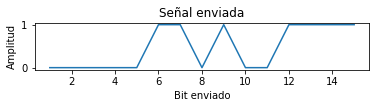

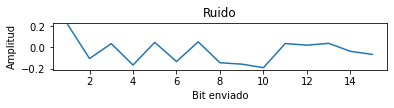

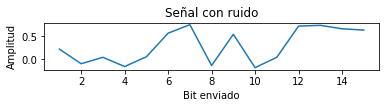

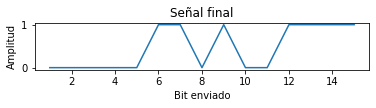

La senal enviada es: [0 0 0 0 0 1 1 0 1 0 1 0 0 0 1]

El ruido anadido a la senal es: [-0.15750166  0.13908968  0.0174604   0.06124374  0.02861686  0.08463159
 -0.35876335 -0.03763035  0.15775866  0.06648557 -0.09701705 -0.23202466
 -0.02145143  0.33938563  0.03181403]

La senal resultante con el ruido es: [-0.15750166  0.13908968  0.0174604   0.06124374  0.02861686  0.78463159
  0.34123665 -0.03763035  0.85775866  0.06648557  0.60298295 -0.23202466
 -0.02145143  0.33938563  0.73181403]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



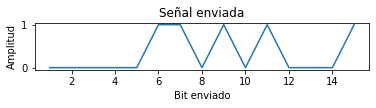

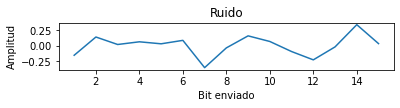

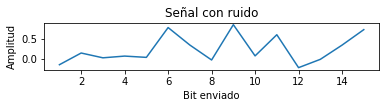

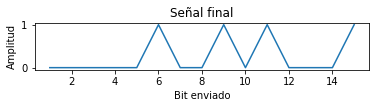

La senal enviada es: [0 0 0 0 0 1 1 0 1 0 1 0 1 1 0]

El ruido anadido a la senal es: [-0.0198962   0.09421544 -0.05379442 -0.08274488 -0.25150955  0.09604018
 -0.0791191   0.19828941 -0.06711052 -0.13077486  0.2192791   0.23605412
 -0.15355281 -0.08775304 -0.27560995]

La senal resultante con el ruido es: [-0.0198962   0.09421544 -0.05379442 -0.08274488 -0.25150955  0.79604018
  0.6208809   0.19828941  0.63288948 -0.13077486  0.9192791   0.23605412
  0.54644719  0.61224696 -0.27560995]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



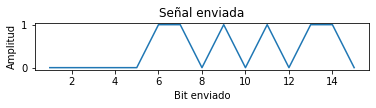

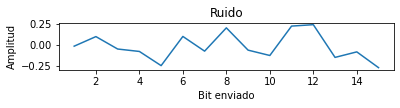

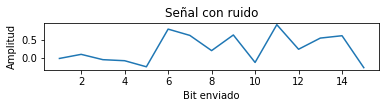

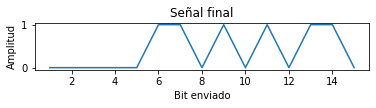

La senal enviada es: [0 0 0 0 0 1 1 0 1 1 0 0 1 0 1]

El ruido anadido a la senal es: [-0.18412303  0.30285728  0.02476894  0.31414919  0.20558139 -0.1302695
  0.14428087 -0.27703983 -0.15600275 -0.01078986  0.11005847  0.00778507
  0.01548544  0.03568595 -0.33880898]

La senal resultante con el ruido es: [-0.18412303  0.30285728  0.02476894  0.31414919  0.20558139  0.5697305
  0.84428087 -0.27703983  0.54399725  0.68921014  0.11005847  0.00778507
  0.71548544  0.03568595  0.36119102]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



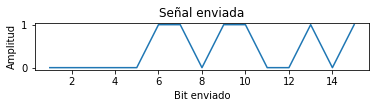

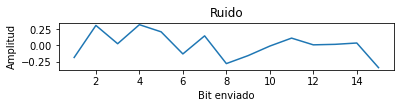

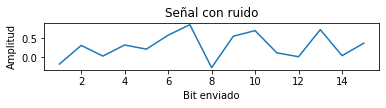

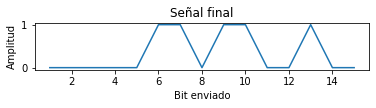

La senal enviada es: [0 0 0 0 0 1 1 0 1 1 0 0 1 0 1]

El ruido anadido a la senal es: [-0.30140456  0.11608876 -0.21206969  0.16486147  0.07369187  0.22409732
  0.12808812  0.02384312 -0.20592692  0.02848918  0.0459769  -0.3174692
  0.09372982 -0.23863481  0.16581447]

La senal resultante con el ruido es: [-0.30140456  0.11608876 -0.21206969  0.16486147  0.07369187  0.92409732
  0.82808812  0.02384312  0.49407308  0.72848918  0.0459769  -0.3174692
  0.79372982 -0.23863481  0.86581447]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



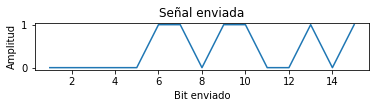

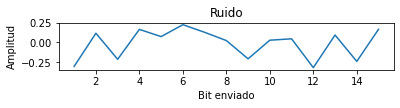

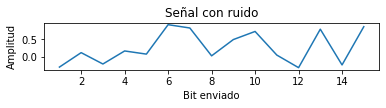

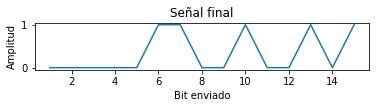

La senal enviada es: [0 0 0 0 0 1 1 0 1 1 1 1 0 1 1]

El ruido anadido a la senal es: [ 0.20406416 -0.28436907 -0.07852941 -0.13308179  0.21040592 -0.17074918
 -0.07107574 -0.24595562  0.03483521  0.04218097  0.22931504 -0.07516604
  0.2861766  -0.15550503  0.01924872]

La senal resultante con el ruido es: [ 0.20406416 -0.28436907 -0.07852941 -0.13308179  0.21040592  0.52925082
  0.62892426 -0.24595562  0.73483521  0.74218097  0.92931504  0.62483396
  0.2861766   0.54449497  0.71924872]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



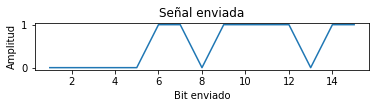

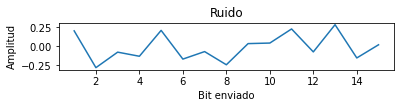

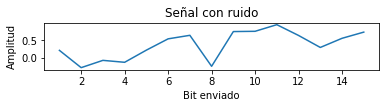

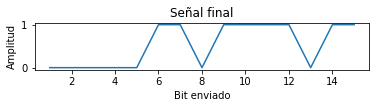

La senal enviada es: [0 0 0 0 1 0 0 1 0 0 0 0 0 1 1]

El ruido anadido a la senal es: [-0.29123724  0.11771183 -0.04407441  0.347502    0.14354766  0.12123466
 -0.1781352   0.30650358  0.02205762  0.1335206   0.05071414  0.23316475
 -0.46105933  0.07870951 -0.04416084]

La senal resultante con el ruido es: [-0.29123724  0.11771183 -0.04407441  0.347502    0.84354766  0.12123466
 -0.1781352   1.00650358  0.02205762  0.1335206   0.05071414  0.23316475
 -0.46105933  0.77870951  0.65583916]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



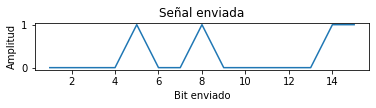

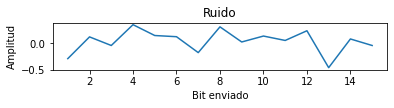

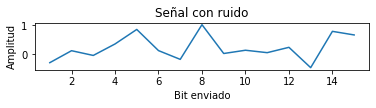

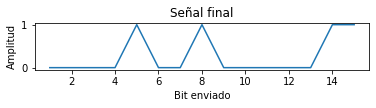

La senal enviada es: [0 0 0 0 1 0 0 1 0 0 0 0 1 0 0]

El ruido anadido a la senal es: [-0.0364456  -0.04455629  0.04955114 -0.02114235  0.2132     -0.15250689
 -0.10086193  0.08399928 -0.15822567 -0.17863812 -0.0136322  -0.01059915
 -0.04764451 -0.03265454 -0.11650554]

La senal resultante con el ruido es: [-0.0364456  -0.04455629  0.04955114 -0.02114235  0.9132     -0.15250689
 -0.10086193  0.78399928 -0.15822567 -0.17863812 -0.0136322  -0.01059915
  0.65235549 -0.03265454 -0.11650554]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



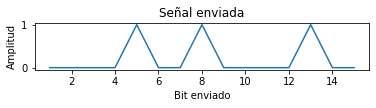

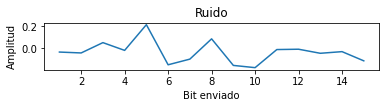

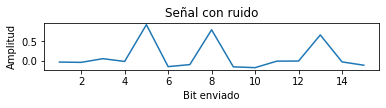

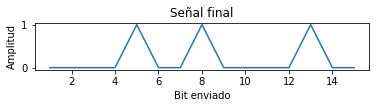

La senal enviada es: [0 0 0 0 1 0 0 1 0 0 0 0 1 0 0]

El ruido anadido a la senal es: [-0.03439605  0.01922909  0.01114826 -0.25914694 -0.17710774  0.02372537
  0.27257131 -0.09781512 -0.27733191 -0.23689489  0.08537385  0.22089427
  0.20042245  0.08449496 -0.1327843 ]

La senal resultante con el ruido es: [-0.03439605  0.01922909  0.01114826 -0.25914694  0.52289226  0.02372537
  0.27257131  0.60218488 -0.27733191 -0.23689489  0.08537385  0.22089427
  0.90042245  0.08449496 -0.1327843 ]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



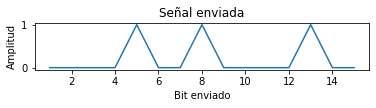

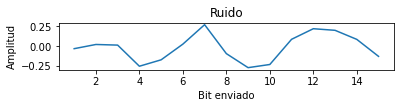

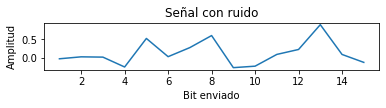

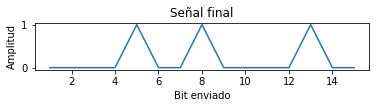

La senal enviada es: [0 0 0 0 1 0 0 1 0 0 0 0 1 0 0]

El ruido anadido a la senal es: [-0.12872453 -0.14381446 -0.0036525   0.12560232  0.125562   -0.05821703
  0.06922535 -0.09220647  0.11352877 -0.01341197  0.04608156 -0.16863243
 -0.34272581  0.00430328 -0.18539515]

La senal resultante con el ruido es: [-0.12872453 -0.14381446 -0.0036525   0.12560232  0.825562   -0.05821703
  0.06922535  0.60779353  0.11352877 -0.01341197  0.04608156 -0.16863243
  0.35727419  0.00430328 -0.18539515]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



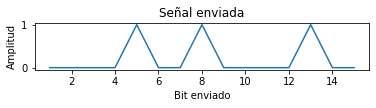

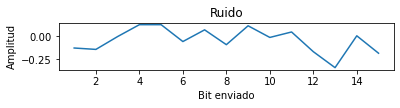

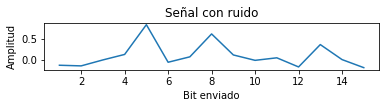

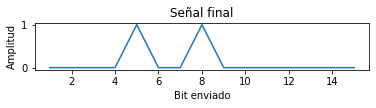

La senal enviada es: [0 0 0 0 1 0 0 1 0 0 1 1 1 0 1]

El ruido anadido a la senal es: [-0.18456193  0.03861471  0.13164955  0.1153824   0.02774746  0.19551936
  0.0895959  -0.2687552  -0.07188918  0.03620076  0.13610231  0.16115912
 -0.05786177  0.13179675 -0.07252926]

La senal resultante con el ruido es: [-0.18456193  0.03861471  0.13164955  0.1153824   0.72774746  0.19551936
  0.0895959   0.4312448  -0.07188918  0.03620076  0.83610231  0.86115912
  0.64213823  0.13179675  0.62747074]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



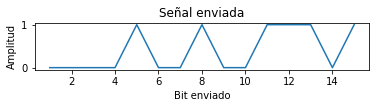

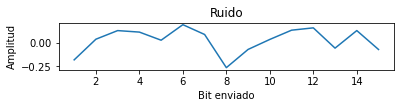

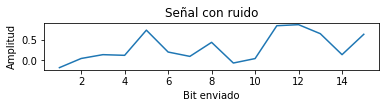

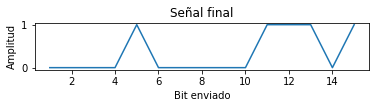

La senal enviada es: [0 0 0 0 1 0 0 1 0 1 0 1 0 0 1]

El ruido anadido a la senal es: [-0.06452002 -0.04230059 -0.13579154 -0.10728081 -0.05147868  0.10999591
 -0.17314683 -0.09977206 -0.23959279  0.19436099 -0.00164074 -0.15842501
  0.09789654 -0.10430324  0.02986987]

La senal resultante con el ruido es: [-0.06452002 -0.04230059 -0.13579154 -0.10728081  0.64852132  0.10999591
 -0.17314683  0.60022794 -0.23959279  0.89436099 -0.00164074  0.54157499
  0.09789654 -0.10430324  0.72986987]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



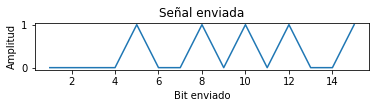

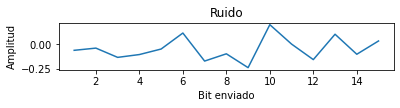

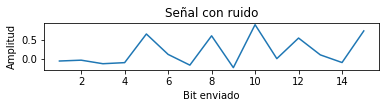

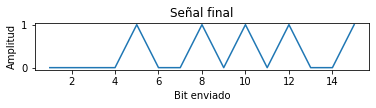

La senal enviada es: [0 0 0 0 1 0 0 1 0 1 0 1 1 1 0]

El ruido anadido a la senal es: [-0.00969625 -0.02226092  0.17822494 -0.01380802  0.23107871  0.04135516
 -0.27613842 -0.10639763 -0.00965553 -0.21448979  0.23283799 -0.04673401
 -0.00269709  0.04452969 -0.04515992]

La senal resultante con el ruido es: [-0.00969625 -0.02226092  0.17822494 -0.01380802  0.93107871  0.04135516
 -0.27613842  0.59360237 -0.00965553  0.48551021  0.23283799  0.65326599
  0.69730291  0.74452969 -0.04515992]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



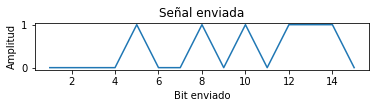

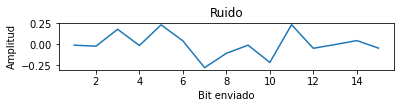

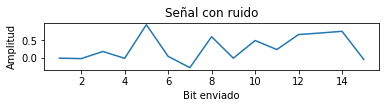

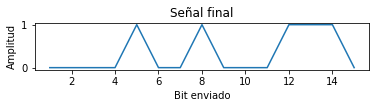

La senal enviada es: [0 0 0 0 1 0 0 1 0 1 1 0 1 1 1]

El ruido anadido a la senal es: [-0.25016999 -0.30994081 -0.53093907  0.22635442 -0.00273928 -0.04437309
 -0.04263587  0.04577194  0.12294911  0.07262919 -0.01925763  0.12595429
 -0.04986309  0.04869382 -0.07577649]

La senal resultante con el ruido es: [-0.25016999 -0.30994081 -0.53093907  0.22635442  0.69726072 -0.04437309
 -0.04263587  0.74577194  0.12294911  0.77262919  0.68074237  0.12595429
  0.65013691  0.74869382  0.62422351]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



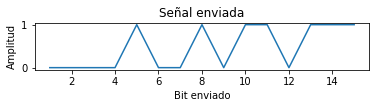

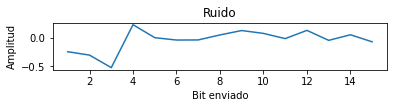

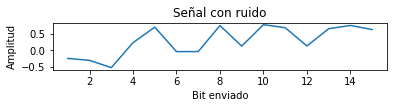

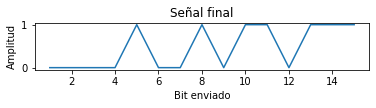

La senal enviada es: [0 0 0 0 1 0 0 1 1 0 0 1 0 0 0]

El ruido anadido a la senal es: [ 0.1801195  -0.03787689  0.33324167  0.36155488  0.03995071  0.21465456
  0.00841135 -0.23037231 -0.08465204 -0.19569825 -0.05478854  0.10549577
 -0.01707143 -0.17515585 -0.41212901]

La senal resultante con el ruido es: [ 0.1801195  -0.03787689  0.33324167  0.36155488  0.73995071  0.21465456
  0.00841135  0.46962769  0.61534796 -0.19569825 -0.05478854  0.80549577
 -0.01707143 -0.17515585 -0.41212901]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



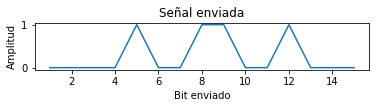

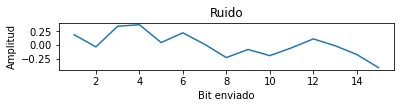

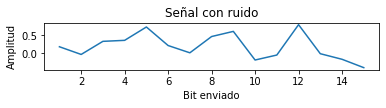

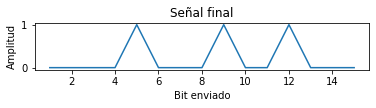

La senal enviada es: [0 0 0 0 1 0 0 1 1 0 0 1 1 1 1]

El ruido anadido a la senal es: [-0.06017679  0.06514109  0.06992551  0.03234461  0.02384366 -0.13319546
 -0.12645027  0.00145027  0.24227472  0.06606144  0.15128451  0.14414743
  0.06911488  0.02522761 -0.04741715]

La senal resultante con el ruido es: [-0.06017679  0.06514109  0.06992551  0.03234461  0.72384366 -0.13319546
 -0.12645027  0.70145027  0.94227472  0.06606144  0.15128451  0.84414743
  0.76911488  0.72522761  0.65258285]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



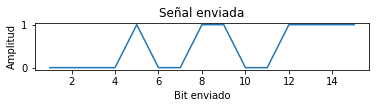

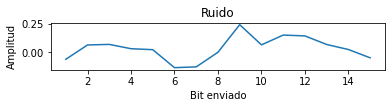

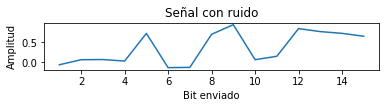

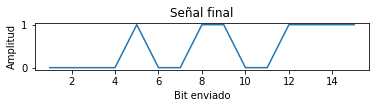

La senal enviada es: [0 0 0 0 1 0 0 1 1 0 1 0 0 0 1]

El ruido anadido a la senal es: [ 0.0299605   0.16578311  0.16862327  0.14510921 -0.07436279 -0.06397778
  0.02025602  0.01498524  0.1479468   0.12795431 -0.14300068 -0.12316929
 -0.01426472  0.25481487 -0.04555682]

La senal resultante con el ruido es: [ 0.0299605   0.16578311  0.16862327  0.14510921  0.62563721 -0.06397778
  0.02025602  0.71498524  0.8479468   0.12795431  0.55699932 -0.12316929
 -0.01426472  0.25481487  0.65444318]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



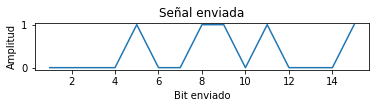

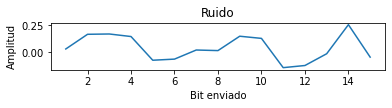

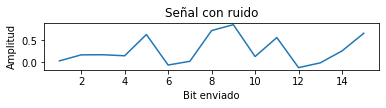

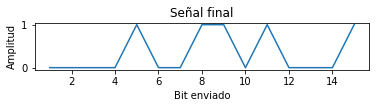

La senal enviada es: [0 0 0 0 1 0 0 1 1 0 1 0 0 0 1]

El ruido anadido a la senal es: [-0.0440389  -0.34528781  0.04857594 -0.04771238  0.09379496  0.23486811
  0.13511345  0.06051112 -0.27463297 -0.36015318 -0.08198609  0.02869959
  0.0077301   0.20104501 -0.10508975]

La senal resultante con el ruido es: [-0.0440389  -0.34528781  0.04857594 -0.04771238  0.79379496  0.23486811
  0.13511345  0.76051112  0.42536703 -0.36015318  0.61801391  0.02869959
  0.0077301   0.20104501  0.59491025]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



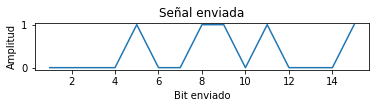

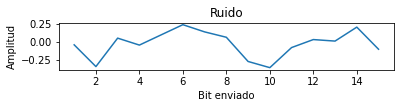

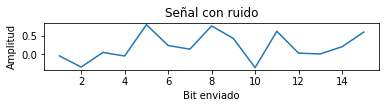

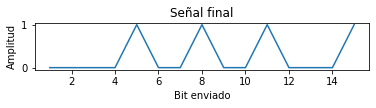

La senal enviada es: [0 0 0 0 1 0 0 1 1 0 0 1 1 1 1]

El ruido anadido a la senal es: [-0.10327444  0.03848431  0.07478314 -0.00208658 -0.09153276  0.00499131
 -0.10214547  0.04793396  0.02454587 -0.13034149  0.22820813 -0.14897289
  0.04457777  0.08875974 -0.3222099 ]

La senal resultante con el ruido es: [-0.10327444  0.03848431  0.07478314 -0.00208658  0.60846724  0.00499131
 -0.10214547  0.74793396  0.72454587 -0.13034149  0.22820813  0.55102711
  0.74457777  0.78875974  0.3777901 ]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



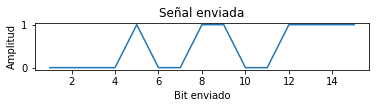

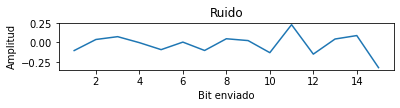

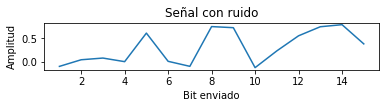

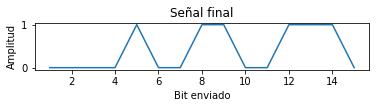

La senal enviada es: [0 0 0 0 1 0 0 1 1 0 0 1 0 0 0]

El ruido anadido a la senal es: [ 0.22629859  0.22795492  0.23234489 -0.00940911 -0.08977898 -0.22459352
  0.40013852  0.16359969  0.16049117 -0.27344538  0.17816137 -0.0829637
 -0.18685129 -0.09312701  0.27499977]

La senal resultante con el ruido es: [ 0.22629859  0.22795492  0.23234489 -0.00940911  0.61022102 -0.22459352
  0.40013852  0.86359969  0.86049117 -0.27344538  0.17816137  0.6170363
 -0.18685129 -0.09312701  0.27499977]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



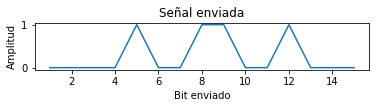

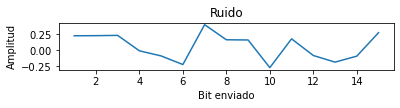

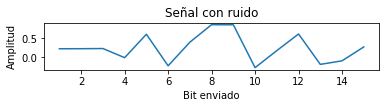

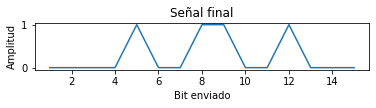

La senal enviada es: [0 0 0 0 1 0 0 1 0 1 1 0 1 1 1]

El ruido anadido a la senal es: [ 0.08510381 -0.06064576  0.0657737  -0.17276887 -0.06407295 -0.09898247
 -0.06122919 -0.10585769 -0.37235314  0.04383123  0.10173946  0.07306717
 -0.10214241  0.28530008 -0.25929694]

La senal resultante con el ruido es: [ 0.08510381 -0.06064576  0.0657737  -0.17276887  0.63592705 -0.09898247
 -0.06122919  0.59414231 -0.37235314  0.74383123  0.80173946  0.07306717
  0.59785759  0.98530008  0.44070306]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



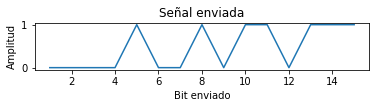

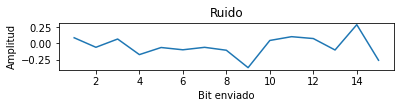

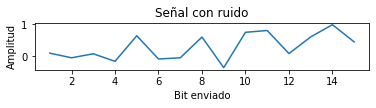

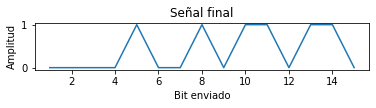

La senal enviada es: [0 0 0 0 1 0 0 1 0 1 0 1 1 1 0]

El ruido anadido a la senal es: [ 0.07106702 -0.14697807  0.01209196 -0.25362166  0.02772394  0.17280011
 -0.04686222  0.21672449  0.16364061 -0.09557795 -0.11747533  0.17952841
  0.08592625  0.17739896 -0.18225607]

La senal resultante con el ruido es: [ 0.07106702 -0.14697807  0.01209196 -0.25362166  0.72772394  0.17280011
 -0.04686222  0.91672449  0.16364061  0.60442205 -0.11747533  0.87952841
  0.78592625  0.87739896 -0.18225607]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



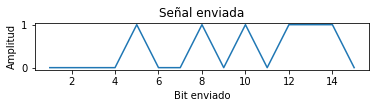

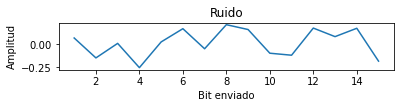

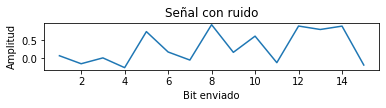

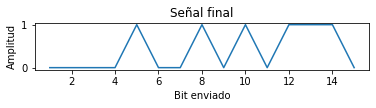

La senal enviada es: [0 0 0 0 1 0 0 1 0 0 1 1 1 0 1]

El ruido anadido a la senal es: [ 0.11824636  0.01008168  0.05084616 -0.04128466  0.27680234  0.21618971
  0.13960744 -0.31906364 -0.28231914 -0.068704    0.20564479  0.13066614
  0.00241208  0.15098477  0.12462382]

La senal resultante con el ruido es: [ 0.11824636  0.01008168  0.05084616 -0.04128466  0.97680234  0.21618971
  0.13960744  0.38093636 -0.28231914 -0.068704    0.90564479  0.83066614
  0.70241208  0.15098477  0.82462382]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



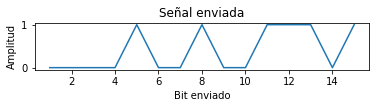

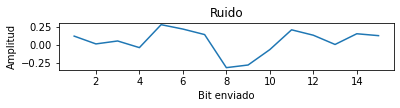

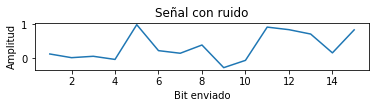

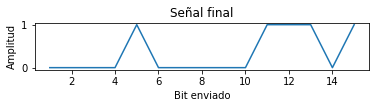

La senal enviada es: [0 0 0 0 1 0 0 1 0 0 0 0 1 0 0]

El ruido anadido a la senal es: [ 0.15108802 -0.10075822 -0.3103237   0.10788845 -0.00802704 -0.12894082
 -0.03594089  0.0737217   0.12088572  0.10246025 -0.03771595 -0.38349344
 -0.18635291 -0.12297051 -0.09100717]

La senal resultante con el ruido es: [ 0.15108802 -0.10075822 -0.3103237   0.10788845  0.69197296 -0.12894082
 -0.03594089  0.7737217   0.12088572  0.10246025 -0.03771595 -0.38349344
  0.51364709 -0.12297051 -0.09100717]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



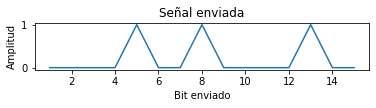

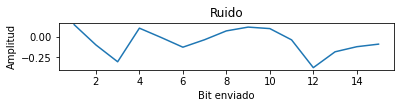

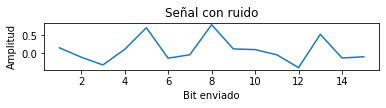

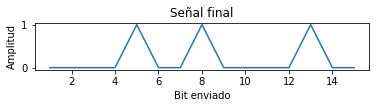

La senal enviada es: [0 0 0 0 1 0 0 1 0 0 0 0 0 1 1]

El ruido anadido a la senal es: [ 0.07444673  0.14541428 -0.14792807  0.13809908  0.23373921  0.41136035
 -0.10006787  0.41502715  0.12045074  0.14786138 -0.02498339  0.07668741
  0.04095489  0.02702573 -0.04090965]

La senal resultante con el ruido es: [ 0.07444673  0.14541428 -0.14792807  0.13809908  0.93373921  0.41136035
 -0.10006787  1.11502715  0.12045074  0.14786138 -0.02498339  0.07668741
  0.04095489  0.72702573  0.65909035]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



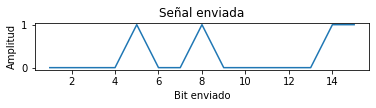

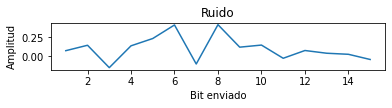

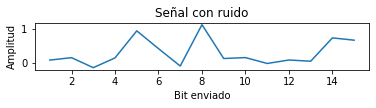

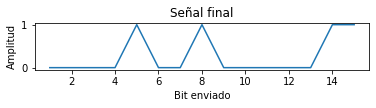

La senal enviada es: [0 0 0 0 0 1 1 0 1 1 1 1 0 1 1]

El ruido anadido a la senal es: [ 0.17579208 -0.38003298  0.28260718 -0.10002097  0.08304667 -0.14340065
 -0.02377245 -0.099865   -0.10877976  0.00346624 -0.11415758  0.02488621
  0.41736894  0.0146587   0.10502222]

La senal resultante con el ruido es: [ 0.17579208 -0.38003298  0.28260718 -0.10002097  0.08304667  0.55659935
  0.67622755 -0.099865    0.59122024  0.70346624  0.58584242  0.72488621
  0.41736894  0.7146587   0.80502222]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



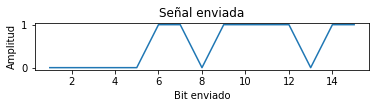

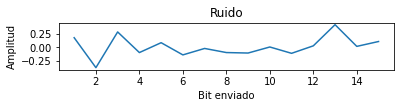

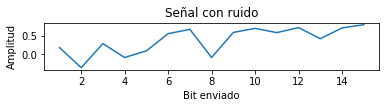

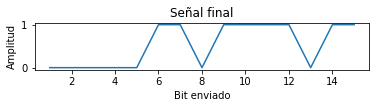

La senal enviada es: [0 0 0 0 0 1 1 0 1 1 0 0 0 1 0]

El ruido anadido a la senal es: [-0.12877959 -0.0856304  -0.07540376  0.09219612  0.01969294 -0.15366902
 -0.16358082  0.16080132  0.14921327  0.1639602   0.3145253   0.06977665
 -0.26665409 -0.20184365 -0.10379043]

La senal resultante con el ruido es: [-0.12877959 -0.0856304  -0.07540376  0.09219612  0.01969294  0.54633098
  0.53641918  0.16080132  0.84921327  0.8639602   0.3145253   0.06977665
 -0.26665409  0.49815635 -0.10379043]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



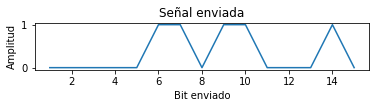

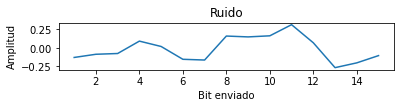

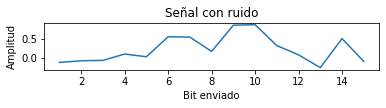

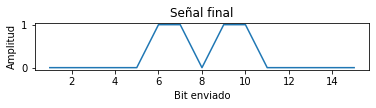

La senal enviada es: [0 0 0 0 0 1 1 0 1 0 1 0 0 0 1]

El ruido anadido a la senal es: [ 0.25248786 -0.32257263  0.06210913 -0.27382722 -0.15273284 -0.29752528
  0.15149151  0.10718996  0.23045767  0.20343906  0.0597988   0.15961681
 -0.1485954  -0.10446897  0.2349128 ]

La senal resultante con el ruido es: [ 0.25248786 -0.32257263  0.06210913 -0.27382722 -0.15273284  0.40247472
  0.85149151  0.10718996  0.93045767  0.20343906  0.7597988   0.15961681
 -0.1485954  -0.10446897  0.9349128 ]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



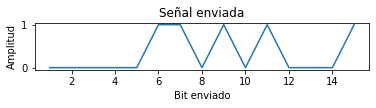

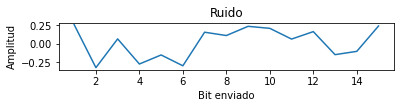

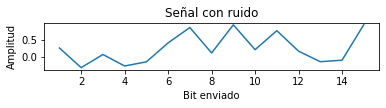

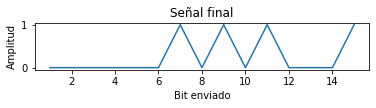

La senal enviada es: [0 0 0 0 0 1 1 0 1 0 0 1 0 0 0]

El ruido anadido a la senal es: [ 0.16295406 -0.16354555 -0.10296494  0.05606916  0.04422022 -0.01184075
 -0.07337054  0.20948147 -0.27329511  0.09762679  0.05357358 -0.20125898
 -0.32143377 -0.0625544   0.03281897]

La senal resultante con el ruido es: [ 0.16295406 -0.16354555 -0.10296494  0.05606916  0.04422022  0.68815925
  0.62662946  0.20948147  0.42670489  0.09762679  0.05357358  0.49874102
 -0.32143377 -0.0625544   0.03281897]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



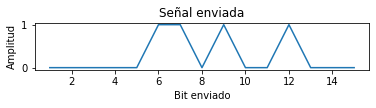

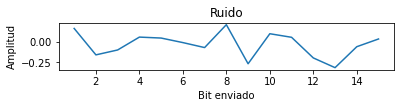

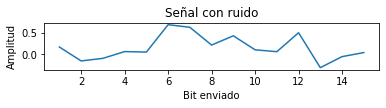

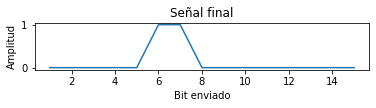

La senal enviada es: [0 0 0 0 0 1 1 0 0 1 1 0 1 1 1]

El ruido anadido a la senal es: [-0.233843   -0.17463859  0.09469169 -0.27130732  0.23082943 -0.21768516
 -0.0198826  -0.10566285 -0.02436565 -0.10247318  0.0343593   0.26604372
  0.16237314  0.11894295  0.16960296]

La senal resultante con el ruido es: [-0.233843   -0.17463859  0.09469169 -0.27130732  0.23082943  0.48231484
  0.6801174  -0.10566285 -0.02436565  0.59752682  0.7343593   0.26604372
  0.86237314  0.81894295  0.86960296]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



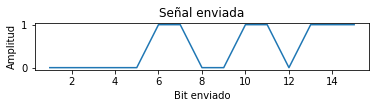

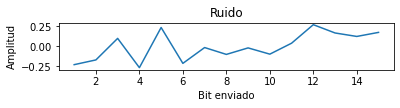

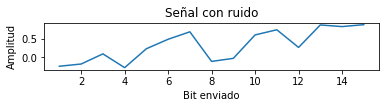

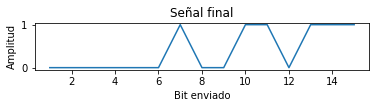

La senal enviada es: [0 0 0 0 0 1 1 0 0 1 1 0 0 0 0]

El ruido anadido a la senal es: [-0.39903535 -0.02564662 -0.14781372 -0.29315807  0.02330382 -0.1830516
 -0.03531249  0.08327936 -0.39891922 -0.0518714  -0.13483403  0.17810563
 -0.11138334  0.28265636  0.14806172]

La senal resultante con el ruido es: [-0.39903535 -0.02564662 -0.14781372 -0.29315807  0.02330382  0.5169484
  0.66468751  0.08327936 -0.39891922  0.6481286   0.56516597  0.17810563
 -0.11138334  0.28265636  0.14806172]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



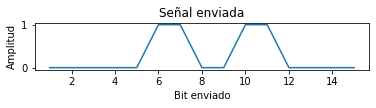

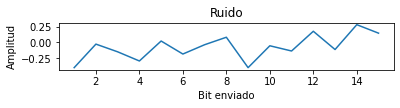

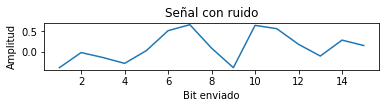

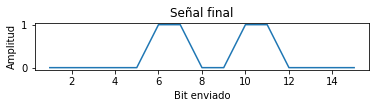

La senal enviada es: [0 0 0 0 0 1 1 0 0 1 0 1 1 1 0]

El ruido anadido a la senal es: [-0.16033447  0.34695375 -0.35558792 -0.15430886 -0.09325551  0.35235088
 -0.17948637 -0.1139415  -0.05808346  0.11379741  0.05309542  0.07212284
  0.03978048 -0.13390647  0.24882752]

La senal resultante con el ruido es: [-0.16033447  0.34695375 -0.35558792 -0.15430886 -0.09325551  1.05235088
  0.52051363 -0.1139415  -0.05808346  0.81379741  0.05309542  0.77212284
  0.73978048  0.56609353  0.24882752]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



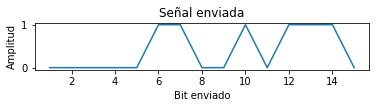

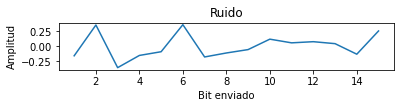

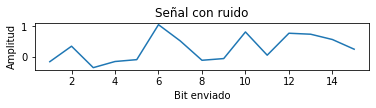

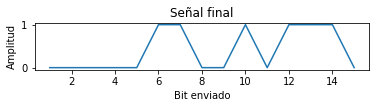

La senal enviada es: [0 0 0 0 0 1 1 0 0 0 1 1 1 0 1]

El ruido anadido a la senal es: [-0.20477164  0.02174071  0.26027597  0.11457486 -0.05444454 -0.24342789
  0.34823849  0.0502432   0.07749609  0.07628471  0.06511371 -0.02696188
  0.36980124  0.22782385  0.22985236]

La senal resultante con el ruido es: [-0.20477164  0.02174071  0.26027597  0.11457486 -0.05444454  0.45657211
  1.04823849  0.0502432   0.07749609  0.07628471  0.76511371  0.67303812
  1.06980124  0.22782385  0.92985236]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



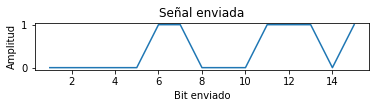

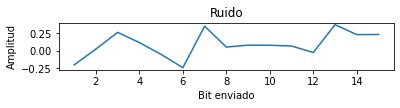

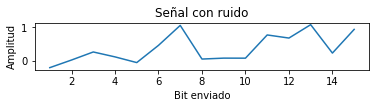

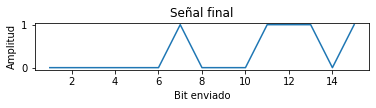

La senal enviada es: [0 0 0 0 0 1 1 0 0 0 0 0 1 0 0]

El ruido anadido a la senal es: [-0.06597516  0.13174967 -0.0805764   0.16576994 -0.05608445 -0.16831894
  0.32958974  0.24793235 -0.27562033  0.04249236 -0.18882069  0.07593546
  0.1976105  -0.27976768 -0.13536136]

La senal resultante con el ruido es: [-0.06597516  0.13174967 -0.0805764   0.16576994 -0.05608445  0.53168106
  1.02958974  0.24793235 -0.27562033  0.04249236 -0.18882069  0.07593546
  0.8976105  -0.27976768 -0.13536136]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



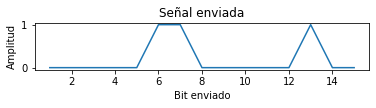

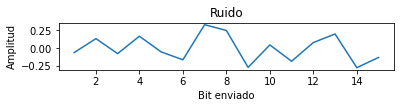

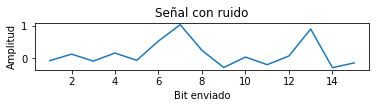

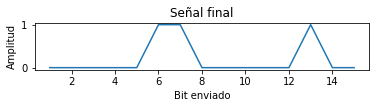

La senal enviada es: [0 0 0 0 0 1 1 0 0 0 0 0 0 1 1]

El ruido anadido a la senal es: [ 0.16871142 -0.20503927  0.15158989 -0.33330223  0.20427623  0.38725991
 -0.11332303  0.22928463 -0.02110887  0.26339075 -0.12232791 -0.2122785
 -0.07630068  0.44838346  0.05618537]

La senal resultante con el ruido es: [ 0.16871142 -0.20503927  0.15158989 -0.33330223  0.20427623  1.08725991
  0.58667697  0.22928463 -0.02110887  0.26339075 -0.12232791 -0.2122785
 -0.07630068  1.14838346  0.75618537]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



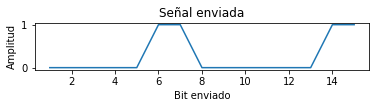

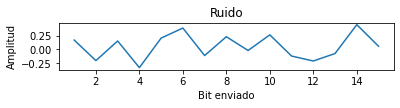

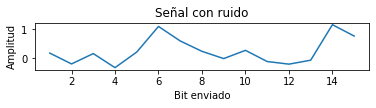

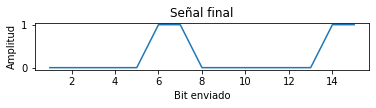

La senal enviada es: [0 0 0 0 0 1 0 1 1 1 1 1 0 1 0]

El ruido anadido a la senal es: [ 0.01188535  0.00092598  0.12630924  0.4266906   0.11914462  0.17184004
 -0.03684614 -0.16723299  0.24416794 -0.17770503 -0.03916082  0.00460111
  0.08111148  0.37016872  0.31743126]

La senal resultante con el ruido es: [ 1.18853501e-02  9.25983038e-04  1.26309245e-01  4.26690596e-01
  1.19144615e-01  8.71840041e-01 -3.68461414e-02  5.32767006e-01
  9.44167941e-01  5.22294970e-01  6.60839179e-01  7.04601109e-01
  8.11114787e-02  1.07016872e+00  3.17431263e-01]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



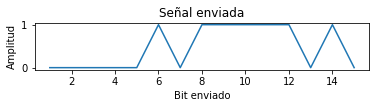

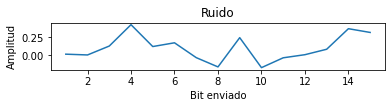

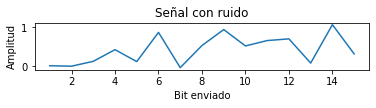

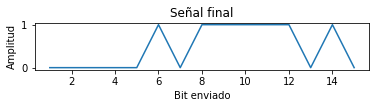

La senal enviada es: [0 0 0 0 0 1 0 1 1 1 0 0 1 0 0]

El ruido anadido a la senal es: [ 0.09877857  0.23581833  0.09154709 -0.05132071  0.12730422 -0.14365232
 -0.02419911  0.0242748  -0.00878492 -0.0475874   0.16728043 -0.3599488
 -0.1215513  -0.17405333 -0.39781715]

La senal resultante con el ruido es: [ 0.09877857  0.23581833  0.09154709 -0.05132071  0.12730422  0.55634768
 -0.02419911  0.7242748   0.69121508  0.6524126   0.16728043 -0.3599488
  0.5784487  -0.17405333 -0.39781715]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



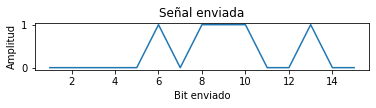

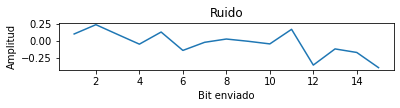

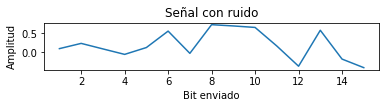

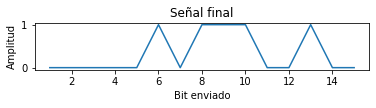

La senal enviada es: [0 0 0 0 0 1 0 1 1 1 0 0 0 1 1]

El ruido anadido a la senal es: [ 0.27326556 -0.08642339 -0.07471324 -0.00782163  0.21721159 -0.35466688
 -0.18427675  0.24637978  0.01643447  0.1039706   0.0803157   0.0785484
  0.03019279 -0.16961612 -0.0778709 ]

La senal resultante con el ruido es: [ 0.27326556 -0.08642339 -0.07471324 -0.00782163  0.21721159  0.34533312
 -0.18427675  0.94637978  0.71643447  0.8039706   0.0803157   0.0785484
  0.03019279  0.53038388  0.6221291 ]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



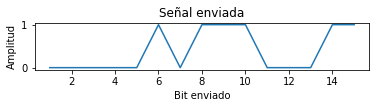

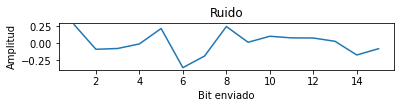

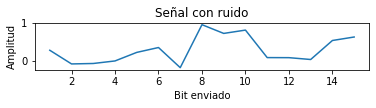

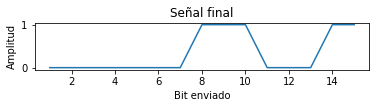

La senal enviada es: [0 0 0 0 0 1 0 1 1 0 1 0 1 1 1]

El ruido anadido a la senal es: [ 0.11900768  0.05657783 -0.08002855  0.15080688 -0.17808838  0.15618008
 -0.01166745 -0.0554596  -0.02750783  0.25410048  0.13133934 -0.03466282
 -0.31858735  0.16019528  0.0219778 ]

La senal resultante con el ruido es: [ 0.11900768  0.05657783 -0.08002855  0.15080688 -0.17808838  0.85618008
 -0.01166745  0.6445404   0.67249217  0.25410048  0.83133934 -0.03466282
  0.38141265  0.86019528  0.7219778 ]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



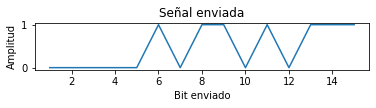

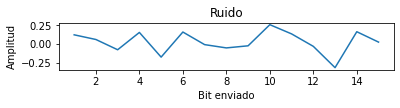

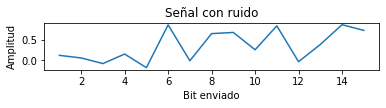

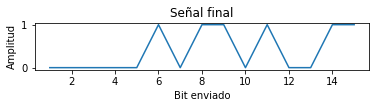

La senal enviada es: [0 0 0 0 0 1 0 1 1 0 1 0 1 1 1]

El ruido anadido a la senal es: [ 0.14707134 -0.20932985  0.06219296  0.21723312  0.04741299  0.20649491
  0.12076966 -0.45567868 -0.4391256   0.36367074  0.13287147 -0.05925724
 -0.2032082  -0.09114279 -0.14637566]

La senal resultante con el ruido es: [ 0.14707134 -0.20932985  0.06219296  0.21723312  0.04741299  0.90649491
  0.12076966  0.24432132  0.2608744   0.36367074  0.83287147 -0.05925724
  0.4967918   0.60885721  0.55362434]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



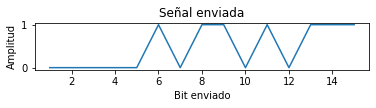

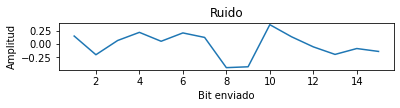

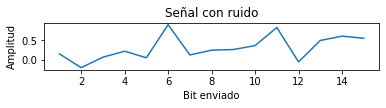

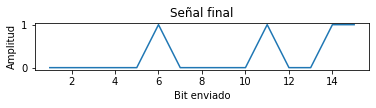

La senal enviada es: [0 0 0 0 0 1 0 1 1 0 1 0 0 0 0]

El ruido anadido a la senal es: [ 0.15635214  0.11071248 -0.23631602  0.06521273  0.18888967 -0.12627396
 -0.22092307 -0.14405652 -0.14070804  0.11776482 -0.03255941 -0.11018464
  0.00680056  0.17597877 -0.13421263]

La senal resultante con el ruido es: [ 0.15635214  0.11071248 -0.23631602  0.06521273  0.18888967  0.57372604
 -0.22092307  0.55594348  0.55929196  0.11776482  0.66744059 -0.11018464
  0.00680056  0.17597877 -0.13421263]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



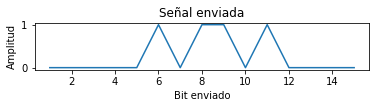

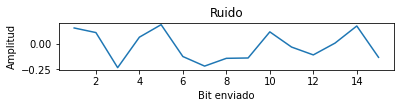

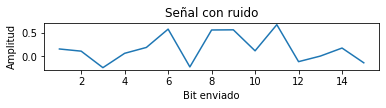

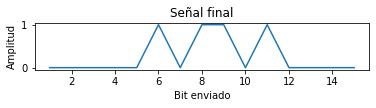

La senal enviada es: [0 0 0 0 0 1 0 1 1 0 0 1 1 1 0]

El ruido anadido a la senal es: [ 0.01920761  0.1758227   0.05170807  0.01630962 -0.28402789  0.35320275
 -0.01612886 -0.02028864  0.18115723 -0.00132933  0.03375231 -0.23853917
  0.31728739 -0.02373385  0.03142733]

La senal resultante con el ruido es: [ 0.01920761  0.1758227   0.05170807  0.01630962 -0.28402789  1.05320275
 -0.01612886  0.67971136  0.88115723 -0.00132933  0.03375231  0.46146083
  1.01728739  0.67626615  0.03142733]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



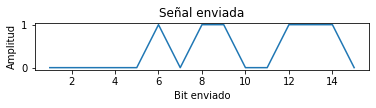

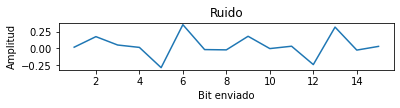

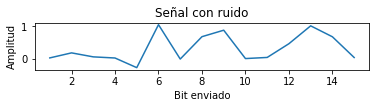

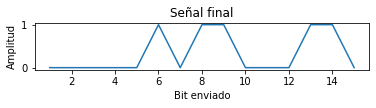

La senal enviada es: [0 0 0 0 0 1 0 1 1 0 0 1 1 1 0]

El ruido anadido a la senal es: [ 0.2645213  -0.11275486 -0.0022086  -0.1305837  -0.13008016 -0.13500589
 -0.0392494  -0.02937042  0.19614918 -0.06495869 -0.10307694  0.05272021
 -0.02960662  0.38803876 -0.14705741]

La senal resultante con el ruido es: [ 0.2645213  -0.11275486 -0.0022086  -0.1305837  -0.13008016  0.56499411
 -0.0392494   0.67062958  0.89614918 -0.06495869 -0.10307694  0.75272021
  0.67039338  1.08803876 -0.14705741]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



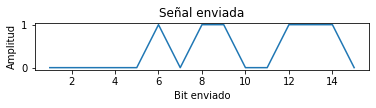

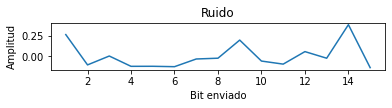

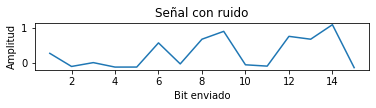

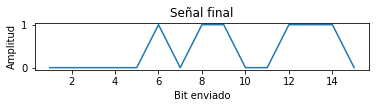

La senal enviada es: [0 0 0 0 0 1 0 1 1 0 0 1 0 0 1]

El ruido anadido a la senal es: [-0.1680118   0.03136504  0.02423975 -0.24493576  0.00447297  0.13328407
  0.07736983  0.23016687 -0.18771222 -0.20872262 -0.07918442 -0.16418403
  0.38744605 -0.28861119 -0.10721479]

La senal resultante con el ruido es: [-0.1680118   0.03136504  0.02423975 -0.24493576  0.00447297  0.83328407
  0.07736983  0.93016687  0.51228778 -0.20872262 -0.07918442  0.53581597
  0.38744605 -0.28861119  0.59278521]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



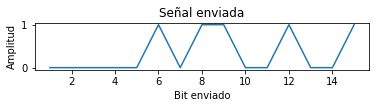

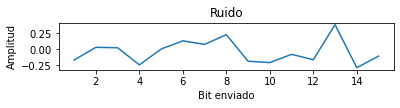

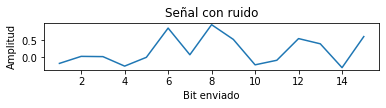

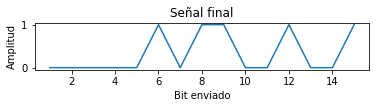

La senal enviada es: [0 0 0 0 0 1 0 1 0 1 1 0 1 1 0]

El ruido anadido a la senal es: [-0.04913812  0.00386084  0.00402067 -0.09400589  0.25720817  0.10351562
 -0.14808347 -0.17707621 -0.09923071  0.17145461 -0.18538132  0.19416959
 -0.08399699 -0.01442092  0.08475427]

La senal resultante con el ruido es: [-0.04913812  0.00386084  0.00402067 -0.09400589  0.25720817  0.80351562
 -0.14808347  0.52292379 -0.09923071  0.87145461  0.51461868  0.19416959
  0.61600301  0.68557908  0.08475427]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



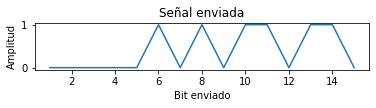

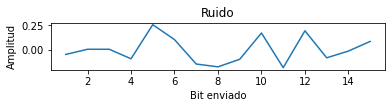

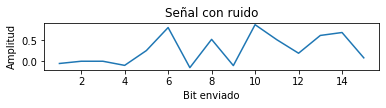

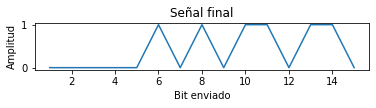

La senal enviada es: [0 0 0 0 0 1 0 1 0 1 1 0 0 0 1]

El ruido anadido a la senal es: [-0.04018794  0.15063753  0.03273669  0.10211524 -0.21223538  0.17696387
  0.1511894  -0.08621989  0.12426969 -0.24164667  0.19679265 -0.21806924
 -0.11679988  0.32942447 -0.00806371]

La senal resultante con el ruido es: [-0.04018794  0.15063753  0.03273669  0.10211524 -0.21223538  0.87696387
  0.1511894   0.61378011  0.12426969  0.45835333  0.89679265 -0.21806924
 -0.11679988  0.32942447  0.69193629]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



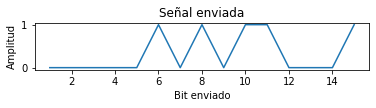

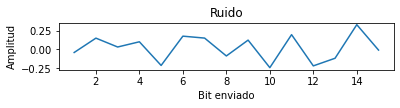

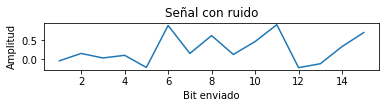

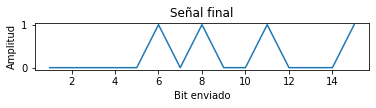

La senal enviada es: [0 0 0 0 0 1 0 1 0 1 1 0 0 0 1]

El ruido anadido a la senal es: [ 1.78092597e-01 -1.38776740e-01  1.82734483e-01 -7.65840983e-02
  2.30125307e-01 -1.03469113e-01  6.80448450e-02  8.91574555e-02
 -1.38014834e-01  3.85386485e-01  2.32446845e-01 -2.56903158e-01
  1.39944754e-01  1.03166508e-04 -9.53365502e-02]

La senal resultante con el ruido es: [ 1.78092597e-01 -1.38776740e-01  1.82734483e-01 -7.65840983e-02
  2.30125307e-01  5.96530887e-01  6.80448450e-02  7.89157455e-01
 -1.38014834e-01  1.08538648e+00  9.32446845e-01 -2.56903158e-01
  1.39944754e-01  1.03166508e-04  6.04663450e-01]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



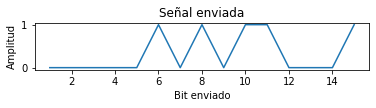

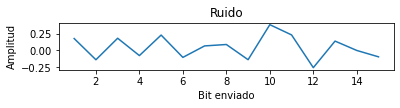

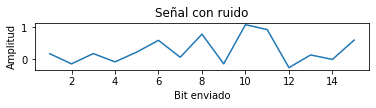

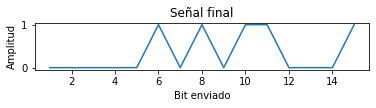

La senal enviada es: [0 0 0 0 0 1 0 1 0 1 1 0 0 0 1]

El ruido anadido a la senal es: [ 0.00085379  0.13057928  0.10535346  0.1967916   0.2044414   0.49438773
  0.15712769  0.0684688   0.24939454 -0.29291313  0.02647093 -0.12748099
 -0.0617192  -0.12377775  0.25663024]

La senal resultante con el ruido es: [ 8.53789090e-04  1.30579280e-01  1.05353461e-01  1.96791605e-01
  2.04441404e-01  1.19438773e+00  1.57127693e-01  7.68468801e-01
  2.49394538e-01  4.07086875e-01  7.26470932e-01 -1.27480995e-01
 -6.17192016e-02 -1.23777752e-01  9.56630236e-01]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



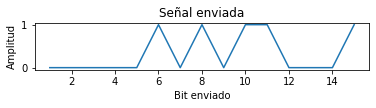

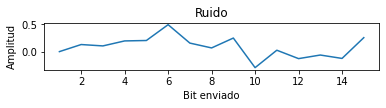

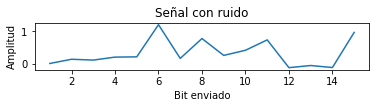

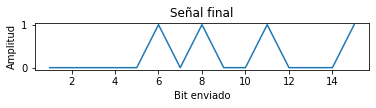

La senal enviada es: [0 0 0 0 0 1 0 1 0 1 1 0 0 0 1]

El ruido anadido a la senal es: [-0.0175593  -0.22828291  0.01142194 -0.15250887 -0.26631138 -0.26296629
  0.09561825 -0.04023813 -0.18874311 -0.04394843  0.17821513 -0.19548502
 -0.14999698  0.07725607 -0.13440562]

La senal resultante con el ruido es: [-0.0175593  -0.22828291  0.01142194 -0.15250887 -0.26631138  0.43703371
  0.09561825  0.65976187 -0.18874311  0.65605157  0.87821513 -0.19548502
 -0.14999698  0.07725607  0.56559438]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



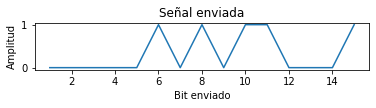

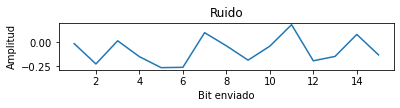

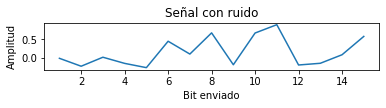

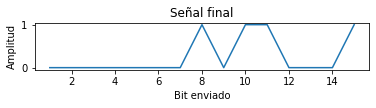

La senal enviada es: [0 0 0 0 0 1 0 1 0 1 0 1 1 1 1]

El ruido anadido a la senal es: [ 0.15682751  0.32191005  0.22817511 -0.04685353  0.09275826  0.08828673
 -0.06146132 -0.04436268 -0.01385585  0.39315571  0.08978078  0.07016127
  0.0243191   0.2923295   0.1496989 ]

La senal resultante con el ruido es: [ 0.15682751  0.32191005  0.22817511 -0.04685353  0.09275826  0.78828673
 -0.06146132  0.65563732 -0.01385585  1.09315571  0.08978078  0.77016127
  0.7243191   0.9923295   0.8496989 ]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



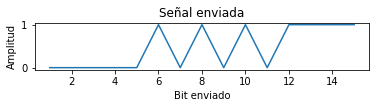

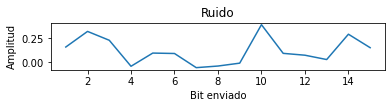

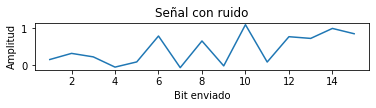

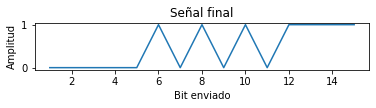

La senal enviada es: [0 0 0 0 0 1 0 1 0 1 0 1 1 1 1]

El ruido anadido a la senal es: [-0.03553024  0.47192029  0.10007285  0.27471053 -0.05897437 -0.14707041
  0.01032238  0.0351751   0.04061988 -0.21182932 -0.32419296 -0.02932934
 -0.11346748 -0.16396583  0.00067836]

La senal resultante con el ruido es: [-0.03553024  0.47192029  0.10007285  0.27471053 -0.05897437  0.55292959
  0.01032238  0.7351751   0.04061988  0.48817068 -0.32419296  0.67067066
  0.58653252  0.53603417  0.70067836]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



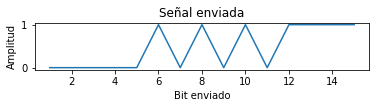

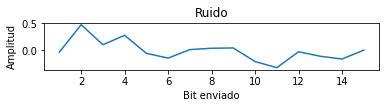

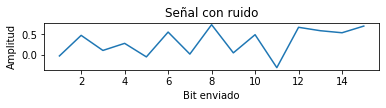

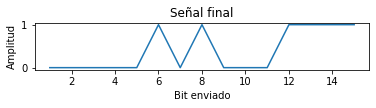

La senal enviada es: [0 0 0 0 0 1 0 1 0 1 0 1 0 0 0]

El ruido anadido a la senal es: [-0.02883999 -0.28166557  0.03355231 -0.22945157  0.07657669 -0.10484622
  0.05437505 -0.14933768  0.02020998 -0.19424054  0.14947122 -0.07399507
  0.04428526 -0.09808288 -0.01642671]

La senal resultante con el ruido es: [-0.02883999 -0.28166557  0.03355231 -0.22945157  0.07657669  0.59515378
  0.05437505  0.55066232  0.02020998  0.50575946  0.14947122  0.62600493
  0.04428526 -0.09808288 -0.01642671]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



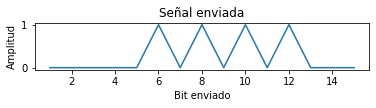

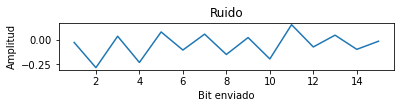

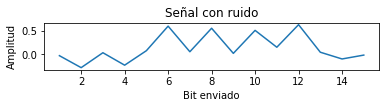

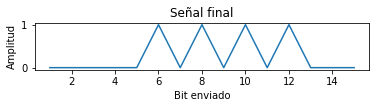

La senal enviada es: [0 0 0 0 0 1 0 1 0 0 1 1 1 0 0]

El ruido anadido a la senal es: [-0.31109024  0.22869723  0.04435626 -0.02118906 -0.04186206  0.01530792
  0.04545922 -0.14139462  0.00875265  0.10813032  0.15185207 -0.41980328
  0.00947355  0.2592514   0.21190202]

La senal resultante con el ruido es: [-0.31109024  0.22869723  0.04435626 -0.02118906 -0.04186206  0.71530792
  0.04545922  0.55860538  0.00875265  0.10813032  0.85185207  0.28019672
  0.70947355  0.2592514   0.21190202]

La senal final recibida por el receptor es con el ruido es: [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0]

El SNR utilizado en fue de 19.6864 y el factor de atenuacion de la senal fue de 0.3, asimismo el valor de umbral fue 0.5 



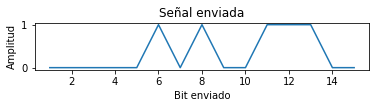

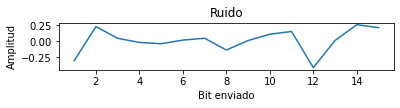

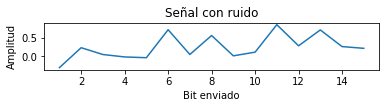

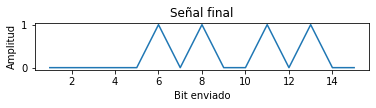

In [40]:
#señal_enviada = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1 ])

#Se crea una lista de listas con los imbolos que ve el receptor
bits_rx = []

#Se crea un for para poder graficar las tramas de bits enviadas por el codigficador hamming, en donde se muestra la señal enviada sin ruido, el ruido a agregar a la señal gaussiano y por utlimo la señal con el ruido gaussiano agregado
for i in range(len(señal_enviada)):
    
    #Se puede configurar la atenuacion de la señal
    atenuacion = 0.3
    
    #Se le suma el ruido a la señal recibida y se le coloca un factor de atenuación
    signal = señal_enviada[i]*(1-atenuacion) + Ruido[i]
    final=[]
    t=0.5 #umbral

    for x in range (len(señal_enviada[i])):
        if (signal[x] > t):
            final.append(1)
        else :
            final.append(0)
    
    #Se añaden los bits que ve el receptor en una lista
    bits_rx.append(final)
    
    print(f'La senal enviada es: {señal_enviada[i]}\n')
    print(f'El ruido anadido a la senal es: {Ruido[i]}\n')
    print(f'La senal resultante con el ruido es: {signal}\n')
    print(f'La senal final recibida por el receptor es con el ruido es: {final}\n')
    print(f'El SNR utilizado en fue de {SNRdB} y el factor de atenuacion de la senal fue de {atenuacion}, asimismo el valor de umbral fue {t} \n')
    
    p=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
    
  
    plt.subplot(4,1,1)
    plt.title('Señal enviada')
    plt.ylabel('Amplitud')
    plt.xlabel('Bit enviado')
    plt.plot(p,señal_enviada[i])
    plt.show()
    
    plt.subplot(4,1,2)
    plt.title('Ruido')
    plt.ylabel('Amplitud')
    plt.xlabel('Bit enviado')
    plt.plot(p,Ruido[i])
    plt.show()

    plt.subplot(4,1,3)
    plt.title('Señal con ruido')
    plt.ylabel('Amplitud')
    plt.xlabel('Bit enviado')
    plt.plot(p,signal)
    plt.show()

    plt.subplot(4,1,4)
    plt.title('Señal final')
    plt.ylabel('Amplitud')
    plt.xlabel('Bit enviado')
    plt.plot(p,final)
    plt.show()


# Para la parte de la Recepción de la Señal

## Para la decodificación 

En esta etapa calculo el vector de error del mensaje recibido
Esto se hace aplicando un XOR comparando la senal enviada con la senal recibida

In [41]:
error_vector_str = []
error_vector = []
bits_rx_str = []

for x in range (len(bits_rx)):
    
    list1 = bits_rx[x]
    list2 = señal_enviada[x]

    result = list(a^b for a,b in zip(list1,list2))
    x = "".join(map(str, result))
    error_vector_str.append(x)
    error_vector.append(result)
    y = "".join(map(str, list1))
    
    bits_rx_str.append(y)

En esta etapa procedo a corregir los errores con ayuda del vector de error 
Esto se hace aplicando un XOR comparando la senal recibida con el vector de error 

In [42]:
dato_corregido = []
dato_corregido_str = []

for x in range (len(error_vector)):
    
    list1 = error_vector[x]
    list2 = bits_rx[x]

    result = list(a^b for a,b in zip(list1,list2))
    x = "".join(map(str, result))
    dato_corregido_str.append(x)
    dato_corregido.append(result)

En esta etapa se calcula el BER, esto lo hacemos contando la cantidad de 1 que tiene el vector de error y dividiendola entre la cantidad de bits enviados

In [43]:
ber_list = []
for x in range (len(error_vector)):
    errors = error_vector[x].count(1)

    N = (len(error_vector[x]))
    ber = 1.0 * errors / N
    ber_list.append(ber)

En esta etapa procedo a decodificar la senal codificada por hamming

In [44]:
bit_sin_hamming_rx = []

bit_sin_hamming_rx_str = []

bit_sin_hamming_rx_sin_correccion = []

bit_sin_hamming_rx_sin_correccion_str = []

i=0
for i in range(len(dato_corregido)):
    
    dato_corregido[i].pop(14)
    dato_corregido[i].pop(13)
    dato_corregido[i].pop(11)
    dato_corregido[i].pop(7)
    
    bits_rx[i].pop(14)
    bits_rx[i].pop(13)
    bits_rx[i].pop(11)
    bits_rx[i].pop(7)

    bit_sin_hamming_rx.append(dato_corregido[i])

    x = "".join(map(str, dato_corregido[i]))
    bit_sin_hamming_rx_str.append(x)
    
    bit_sin_hamming_rx_sin_correccion.append(bits_rx[i])

    y = "".join(map(str, bits_rx[i]))
    bit_sin_hamming_rx_sin_correccion_str.append(y)
    
    i=i+1

En esta etapa una vez teniendo la senal digital decodificada,
Procedemos a convertir la senal digital a un valor analogico

In [45]:
datos_decodificados = []
datos_decodificados_no_corregidos = []

i = 0 
for i in range(len(bit_sin_hamming_rx_str)):
    x = int(bit_sin_hamming_rx_str[i],2) + 90
    datos_decodificados.append(x)
    
    y = int(bit_sin_hamming_rx_sin_correccion_str[i],2) + 90
    datos_decodificados_no_corregidos.append(y)
    i = i + 1

En esta etapa se procede a imprimir los datos

In [46]:
i = 0
for data  in BPM_BIN_7bits:  # Para añadir los bits transmitidos

# Se calcula los requerimientos de los bits de redundancia
    m = len(data)
    r = calcRedundantBits(m)

# Se determina la posicion de los bits de redundancia
    arreglo = posRedundantBits(data, r)

# Se determinan los bits de paridad
    arreglo = calcParidadtyBits(arreglo, r)

#Se muestra al usuario los datos transferidos, así como el error de datos y la pos del error

    print("El número de Iteración es: " + str(i))
    print("El dato enviado es:" + arreglo) 
        # si se modifica el arreglo qeu contiene el mensaje para insertarle un error
        # el algoritmo detectaria en cual posicion esta el error
        # 000000000000000 -> 000000000000010
    print("El dato recibido es: " + bits_rx_str[i])
    Vector_error = error_vector_str[i]
    print("El vector de error es: " + Vector_error)
    correction = detectError(Vector_error, r)
    print("La posisición del error es: " + str(correction))
    print("El BER es: " + str(ber_list[i]))
    print("El SNR es: " + str(SNRdB))
    print("El dato corregido es: " + dato_corregido_str[i])
    print("El dato Deco Hamming: " + bit_sin_hamming_rx_str[i])
    print("El dato Decodificado: " + str(datos_decodificados[i]))
    print("El dato Decodificado sin corregir: " + str(datos_decodificados_no_corregidos[i]))
    print ('------------------------------------- \n')
    i = i + 1

El número de Iteración es: 0
El dato enviado es:000000000000000
El dato recibido es: 000000000000001
El vector de error es: 000000000000001
La posisición del error es: 1
El BER es: 0.06666666666666667
El SNR es: 19.6864
El dato corregido es: 000000000000000
El dato Deco Hamming: 00000000000
El dato Decodificado: 90
El dato Decodificado sin corregir: 90
------------------------------------- 

El número de Iteración es: 1
El dato enviado es:000000000000111
El dato recibido es: 000000000000111
El vector de error es: 000000000000000
La posisición del error es: 0
El BER es: 0.0
El SNR es: 19.6864
El dato corregido es: 000000000000111
El dato Deco Hamming: 00000000001
El dato Decodificado: 91
El dato Decodificado sin corregir: 91
------------------------------------- 

El número de Iteración es: 2
El dato enviado es:000000000011001
El dato recibido es: 000000000011001
El vector de error es: 000000000000000
La posisición del error es: 0
El BER es: 0.0
El SNR es: 19.6864
El dato corregido es: 

In [47]:
Comparacion_df['Datos decodificados y corregidos']=datos_decodificados
Comparacion_df['Datos decodificados sin corregir'] = datos_decodificados_no_corregidos


In [48]:
t = np.array(Comparacion_df["Tiempo(s)"])

In [55]:
import statistics

media_ber = statistics.mean(ber_list_porcentaje)
media_bpm = statistics.mean(datos_decodificados)

In [50]:
ber_list_porcentaje = np.array(ber_list)

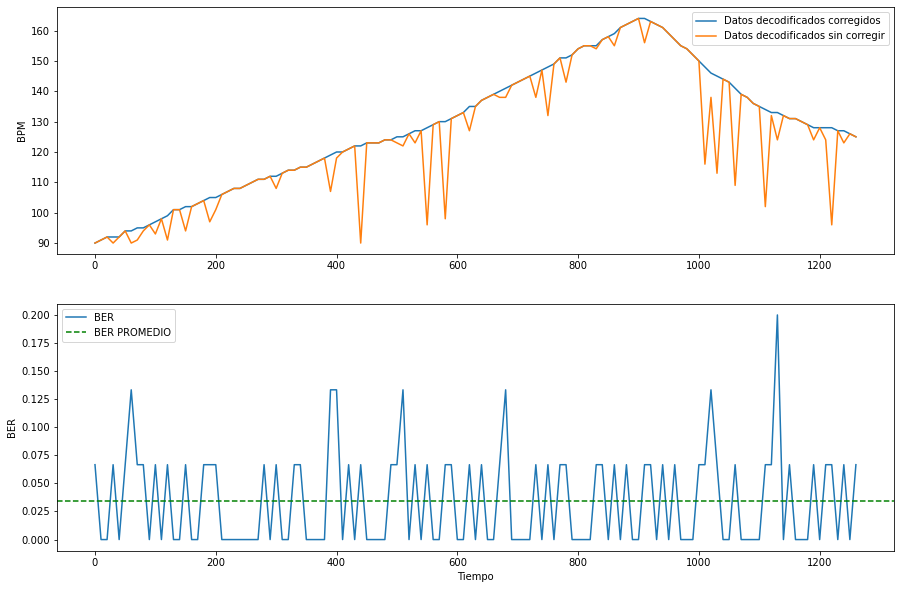

In [58]:
fig, axs = plt.subplots(2)
plt.rcParams['figure.figsize'] = [15, 10]
  
axs[0].plot(t, datos_decodificados, label = "Datos decodificados corregidos", )
axs[0].plot(t, datos_decodificados_no_corregidos, label = "Datos decodificados sin corregir")

#plt.axhline(y=media_bpm, color ="green", linestyle ="--", label = "BPM Promedio")

axs[1].plot(t, ber_list_porcentaje, label = "BER", )

# naming the x axis
plt.xlabel('Tiempo')
# naming the y axis
plt.setp(axs[0], ylabel='BPM')
plt.setp(axs[1], ylabel='BER')

axs[1].axhline(y=media_ber, color ="green", linestyle ="--", label = "BER PROMEDIO")

axs[0].legend()
axs[1].legend()
plt.show()

# Para la Visualización

In [52]:
# Se procede a calcular la frecuencia cardiaca maxima para una persona de 32 años

edad = 32
FCM = 208.75-(0.73 * edad)

#Se calculan las distintas zonas de entrenamiento
calentamiento = 0.65 * FCM # < 65% FCM
quema_grasa = 0.80 * FCM # <80% FCM 
aeróbica = 0.85 * FCM  #<85% FCM
anaeróbica = 0.9 * FCM  #<90% FCM
extrema = 0.95 * FCM  #95% FCM

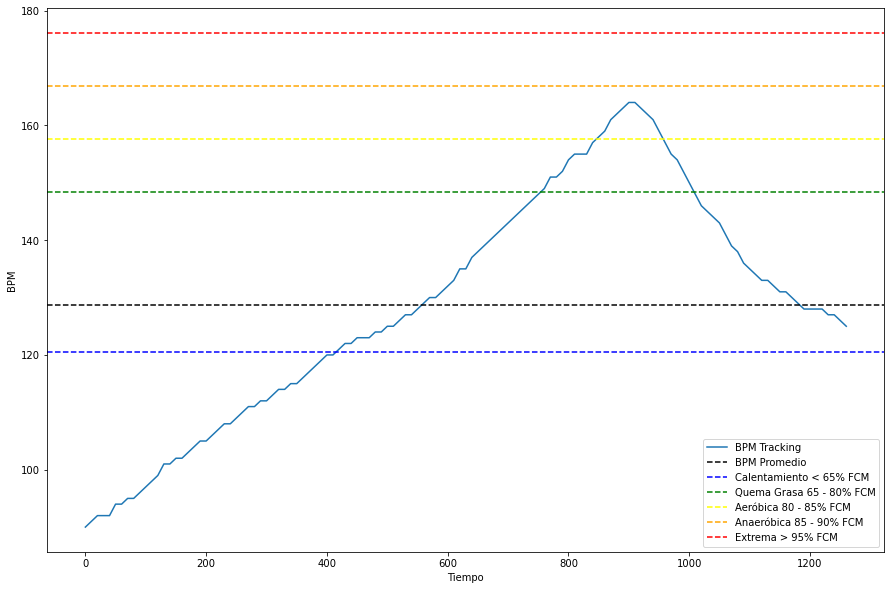

In [53]:
plt.rcParams['figure.figsize'] = [15, 10]
  
plt.plot(t, datos_decodificados, label = "BPM Tracking", )
#plt.plot(t, datos_decodificados_no_corregidos, label = "Datos decodificados sin corregir")

plt.axhline(y=media_bpm, color ="black", linestyle ="--", label = "BPM Promedio")

#Zonas de Entrenamiento
plt.axhline(y=calentamiento, color ="blue", linestyle ="--", label = "Calentamiento < 65% FCM")
plt.axhline(y=quema_grasa, color ="green", linestyle ="--", label = "Quema Grasa 65 - 80% FCM")
plt.axhline(y=aeróbica, color ="yellow", linestyle ="--", label = "Aeróbica 80 - 85% FCM")
plt.axhline(y=anaeróbica, color ="orange", linestyle ="--", label = "Anaeróbica 85 - 90% FCM")
plt.axhline(y=extrema, color ="red", linestyle ="--", label = "Extrema > 95% FCM")


# naming the x axis
plt.xlabel('Tiempo')
# naming the y axis
plt.ylabel('BPM')

plt.legend()
plt.show()